In [ ]:
from collections import defaultdict
from datetime import datetime
import pandas as pd
import re
from pymongo import MongoClient

pd.set_option('display.max_columns', None)  # Show all columns in DataFrame output

# Establish database connections
mongoClient = MongoClient("mongodb://localhost:27017/")
db_polymarket = mongoClient["polygon_polymarket"]
db_orderbook = mongoClient["the-graph-polymarket-orderbook"]

# Get collections
fpmms_collection = db_polymarket["fpmms"]
fpmmSell = db_polymarket["FPMMSell"]
fpmmBuy = db_polymarket["FPMMBuy"]
fpmmFundingAdded = db_polymarket["FPMMFundingAdded"]
fpmmFundingRemoved = db_polymarket["FPMMFundingRemoved"]
conditions_new = db_orderbook["conditions-new"]
redemptions = db_orderbook["redemptions"]
splits = db_orderbook["splits"]
merges = db_orderbook["merges"]

# Read the file and extract AMM addresses
relevant_amms = []

try:
    with open('relevant_amms.txt', 'r') as file:
        for line in file:
            # Look for lines containing "Processed" followed by a hex address
            match = re.search(r'Processed\s+(0x[a-fA-F0-9]+)', line.strip())
            if match:
                amm_address = match.group(1).lower()  # Convert to lowercase for consistency
                relevant_amms.append(amm_address)
    
    print(f"Successfully extracted {len(relevant_amms)} AMM addresses from relevant_amms.txt")
    print(f"First few addresses: {relevant_amms[:5]}")
    
except FileNotFoundError:
    print("relevant_amms.txt file not found. Please make sure the file exists in the current directory.")
except Exception as e:
    print(f"Error reading file: {e}")

# --- Data Loading ---
# Using a limit of 100 for demonstration. You can remove this for a full analysis.
amm_based_fpmms = list(fpmms_collection.find({"fpmm_address": {"$in": relevant_amms}}))
print(f"Found {len(amm_based_fpmms)} AMMs to process.")

# Get all FPMM addresses and condition IDs upfront
fpmm_addresses = [fpmm["fpmm_address"].lower() for fpmm in amm_based_fpmms]
fpmm_condition_ids = [fpmm["conditionId"] for fpmm in amm_based_fpmms]

# Query all conditions and redemptions once
conditions_filtered = list(conditions_new.find({"id": {"$in": fpmm_condition_ids}}))
redemptions_filtered = list(redemptions.find({"condition.id": {"$in": fpmm_condition_ids}}))

# Query splits and merges for the relevant conditions
splits_filtered = list(splits.find({"condition.id": {"$in": fpmm_condition_ids}}))
merges_filtered = list(merges.find({"condition.id": {"$in": fpmm_condition_ids}}))

conditions_by_id = {c["id"]: c for c in conditions_filtered}
redemptions_by_condition = defaultdict(list)
for r in redemptions_filtered:
    redemptions_by_condition[r["condition"]["id"]].append(r)

# Group splits and merges by condition ID
splits_by_condition = defaultdict(list)
for s in splits_filtered:
    splits_by_condition[s["condition"]["id"]].append(s)

merges_by_condition = defaultdict(list)
for m in merges_filtered:
    merges_by_condition[m["condition"]["id"]].append(m)

# --- Query all events once and group by FPMM ---
print("Querying all events from database...")

count = 0
# Group funding events by FPMM address
funding_added_by_fpmm = defaultdict(list)
for e in fpmmFundingAdded.find({"fpmm_address": {"$in": fpmm_addresses}}):
    funding_added_by_fpmm[e["fpmm_address"].lower()].append(e)

funding_removed_by_fpmm = defaultdict(list)
for e in fpmmFundingRemoved.find({"fpmm_address": {"$in": fpmm_addresses}}):
    funding_removed_by_fpmm[e["fpmm_address"].lower()].append(e)

# Group trading events by FPMM address
sell_events_by_fpmm = defaultdict(list)
for e in fpmmSell.find({"fpmm_address": {"$in": fpmm_addresses}}):
    sell_events_by_fpmm[e["fpmm_address"].lower()].append(e)

buy_events_by_fpmm = defaultdict(list)
for e in fpmmBuy.find({"fpmm_address": {"$in": fpmm_addresses}}):
    buy_events_by_fpmm[e["fpmm_address"].lower()].append(e)

print("Database queries completed. Processing events...")

# --- Event Processing ---
all_events = []
for fpmm in amm_based_fpmms:
    fpmm_address = fpmm["fpmm_address"].lower()
    condition_id = fpmm["conditionId"].lower()
    fee = fpmm.get("fee", 0) / 1e18
    
    condition_details = conditions_by_id.get(condition_id)
    if not condition_details or not condition_details.get("resolutionTimestamp"):
        continue
        
    resolution_timestamp = int(condition_details["resolutionTimestamp"])
    
    # Find all unique LPs for this market from the pre-loaded funding events
    lps = set(e["funder"].lower() for e in funding_added_by_fpmm.get(fpmm_address, []))
    if not lps:
        continue

    # Collect all existing transaction hashes to avoid duplicates
    existing_hashes = set()
    
    # Process funding events for this FPMM using pre-loaded data
    for e in funding_added_by_fpmm.get(fpmm_address, []):
        tx_hash = e.get("transaction_hash", None)
        if tx_hash:
            existing_hashes.add(tx_hash.lower())
        all_events.append({
            "fpmm": fpmm_address, 
            "fee": fee,
            "lp": e["funder"].lower(), 
            "type": "FundingAdded", 
            "amount": e.get("collateralAmount", 0) , 
            "timestamp": e["timestamp"], 
            "resolution_timestamp": resolution_timestamp,
            "asset_id": "USDC",
            "quantity": e.get('amountsAdded', []),
            "price": (
                [0] * len(e['amountsAdded']) if e.get('amountsAdded') and len(e['amountsAdded']) >= 2 and sum(e['amountsAdded']) == 0
                else [
                    amt / sum(e['amountsAdded']) for amt in reversed(e['amountsAdded'])
                ] if e.get('amountsAdded') and len(e['amountsAdded']) >= 2 and sum(e['amountsAdded']) > 0
                else None
            ),
            "hash": tx_hash,
            "cpmmFee": e.get("CPMMFee", 0),
            "sharesMinted": e.get("sharesMinted", 0),
            "sharesBurnt": e.get("sharesBurnt", 0)
        })
    
    for e in funding_removed_by_fpmm.get(fpmm_address, []):
        tx_hash = e.get("transaction_hash", None)
        if tx_hash:
            existing_hashes.add(tx_hash.lower())
        all_events.append({
            "fpmm": fpmm_address, 
            "fee": fee,
            "lp": e["funder"].lower(), 
            "type": "FundingRemoved", 
            "amount": e.get("collateralRemovedFromFeePool", 0), 
            "timestamp": e["timestamp"], 
            "resolution_timestamp": resolution_timestamp,
            "asset_id": "USDC",
            "quantity": e.get('amountsRemoved', []),
            "price": (
                [0] * len(e['amountsRemoved']) if e.get('amountsRemoved') and len(e['amountsRemoved']) >= 2 and sum(e['amountsRemoved']) == 0
                else [
                    amt / sum(e['amountsRemoved']) for amt in reversed(e['amountsRemoved'])
                ] if e.get('amountsRemoved') and len(e['amountsRemoved']) >= 2 and sum(e['amountsRemoved']) > 0
                else None
            ),
            "hash": tx_hash,
            "cpmmFee": e.get("CPMMFee", 0),
            "sharesMinted": e.get("sharesMinted", 0),
            "sharesBurnt": e.get("sharesBurnt", 0)
        })
    
    # Only include sell/buy events from LPs (traders who are also LPs)
    for e in sell_events_by_fpmm.get(fpmm_address, []):
        if e["trader"].lower() in lps:
            tx_hash = e.get("transaction_hash", None)
            if tx_hash:
                existing_hashes.add(tx_hash.lower())
            all_events.append({
                "fpmm": fpmm_address, 
                "fee": fee,
                "lp": e["trader"].lower(), 
                "type": "Sell", 
                "amount": e.get("outputAmount", 0), 
                "timestamp": e["timestamp"], 
                "resolution_timestamp": resolution_timestamp,
                "asset_id": e.get("inputAssetId", "USDC"),
                "quantity": [e.get("inputAmount", 0)],
                "price": [(e.get("outputAmount", 0) / e.get("inputAmount", 1))] if e.get("inputAmount") else [],
                "hash": tx_hash,
                "cpmmFee": e.get("CPMMFee", 0),
                "sharesMinted": e.get("sharesMinted", 0),
                "sharesBurnt": e.get("sharesBurnt", 0)                
            })
        
    for e in buy_events_by_fpmm.get(fpmm_address, []):
        if e["trader"].lower() in lps:
            tx_hash = e.get("transaction_hash", None)
            if tx_hash:
                existing_hashes.add(tx_hash.lower())
            all_events.append({
                "fpmm": fpmm_address, 
                "fee": fee,
                "lp": e["trader"].lower(), 
                "type": "Buy", 
                "amount": e.get("inputAmount", 0) , 
                "timestamp": e["timestamp"], 
                "resolution_timestamp": resolution_timestamp,
                "asset_id": e.get("outputAssetId", "USDC"),
                "quantity": [e.get("outputAmount", 0)],
                "price": [(e.get("inputAmount", 0) / e.get("outputAmount", 1))] if e.get("outputAmount") else [],
                "hash": tx_hash,
                "cpmmFee": e.get("CPMMFee", 0),
                "sharesMinted": e.get("sharesMinted", 0),
                "sharesBurnt": e.get("sharesBurnt", 0)                
            })
    
    # Process redemptions for this condition
    for e in redemptions_by_condition.get(condition_id, []):
        if e["redeemer"]["id"].lower() in lps:
            tx_hash = e.get("id", None).lower()  # id is the transaction hash
            if tx_hash:
                existing_hashes.add(tx_hash.lower())
            all_events.append({
                "fpmm": fpmm_address, 
                "fee": fee,
                "lp": e["redeemer"]["id"].lower(), 
                "type": "Redemption", 
                "amount": float(e.get("payout", 0)) , 
                "timestamp": int(e["timestamp"]), 
                "resolution_timestamp": resolution_timestamp,
                "asset_id": "USDC",
                "quantity": [],
                "price": [],
                "hash": tx_hash,
                "cpmmFee": e.get("CPMMFee", 0),
                "sharesMinted": e.get("sharesMinted", 0),
                "sharesBurnt": e.get("sharesBurnt", 0)                           
            })
    
    # Process splits for this condition (only if LP and hash not already seen)
    for e in splits_by_condition.get(condition_id, []):
        stakeholder_id = e["stakeholder"]["id"].lower()
        tx_hash = e["id"].lower()  # id is the transaction hash
        
        if stakeholder_id in lps and tx_hash not in existing_hashes:
            all_events.append({
                "fpmm": fpmm_address, 
                "fee": fee,
                "lp": stakeholder_id, 
                "type": "Split", 
                "amount": float(e["amount"]),  # Convert string to float and normalize
                "timestamp": int(e["timestamp"]), 
                "resolution_timestamp": resolution_timestamp,
                "asset_id": "USDC",
                "quantity": [],
                "price": [],
                "hash": tx_hash,
                "cpmmFee": e.get("CPMMFee", 0),
                "sharesMinted": e.get("sharesMinted", 0),
                "sharesBurnt": e.get("sharesBurnt", 0)                           
            })
    
    # Process merges for this condition (only if LP and hash not already seen)
    for e in merges_by_condition.get(condition_id, []):
        stakeholder_id = e["stakeholder"]["id"].lower()
        tx_hash = e["id"].lower()  # id is the transaction hash
        
        if stakeholder_id in lps and tx_hash not in existing_hashes:
            all_events.append({
                "fpmm": fpmm_address, 
                "fee": fee,
                "lp": stakeholder_id, 
                "type": "Merge", 
                "amount": float(e["amount"]) ,  # Convert string to float and normalize
                "timestamp": int(e["timestamp"]), 
                "resolution_timestamp": resolution_timestamp,
                "asset_id": "USDC",
                "quantity": [],
                "price": [],
                "hash": tx_hash,
                "cpmmFee": e.get("CPMMFee", 0),
                "sharesMinted": e.get("sharesMinted", 0),
                "sharesBurnt": e.get("sharesBurnt", 0)                           
            })

# --- DataFrame Creation ---
df = pd.DataFrame(all_events)
if not df.empty:
    df['timestamp_dt'] = pd.to_datetime(df['timestamp'], unit='s')
    df['resolution_dt'] = pd.to_datetime(df['resolution_timestamp'], unit='s')
    df['relative_time_hours'] = (df['timestamp_dt'] - df['resolution_dt']).dt.total_seconds() / 3600
    print(f"Successfully processed {len(df)} events into a DataFrame.")
    print(f"Event types found: {df['type'].value_counts().to_dict()}")
    print(df.head())
else:
    print("No events found for the selected AMMs.")

Successfully extracted 2643 AMM addresses from relevant_amms.txt
First few addresses: ['0x0464dd2ba3a8100f2ce7c7217559684a63a37699', '0x0456cd5c6f4c7d6464605b892fd85c7a09b00cac', '0x046aa9b95e5f45da6821dea98e6aa684e6b92c65', '0x049cc4d8932fdc33ee568406cdf81d832655340c', '0x04a2962b2ada3007a4ae68ac0d853b0056f33179']
Found 2643 AMMs to process.
Querying all events from database...
Database queries completed. Processing events...
Successfully processed 379325 events into a DataFrame.
Event types found: {'Sell': 110858, 'Buy': 91646, 'FundingAdded': 64114, 'FundingRemoved': 58596, 'Merge': 39445, 'Redemption': 12326, 'Split': 2340}
                                         fpmm   fee  \
0  0x049cc4d8932fdc33ee568406cdf81d832655340c  0.09   
1  0x049cc4d8932fdc33ee568406cdf81d832655340c  0.09   
2  0x049cc4d8932fdc33ee568406cdf81d832655340c  0.09   
3  0x049cc4d8932fdc33ee568406cdf81d832655340c  0.09   
4  0x049cc4d8932fdc33ee568406cdf81d832655340c  0.09   

                                 

In [64]:
import numpy as np

selected_fpmm = "0x08bb711d436f79a740c8c5427a58928e53236614".lower()
selected_lp = "0x9d84ce0306f8551e02efef1680475fc0f1dc1344".lower()

def format_price_array(x):
    # Handle None/NaN cases first
    if x is None:
        return []
    
    # If it's an array/list, check if it's empty or contains NaN
    if isinstance(x, (list, np.ndarray)):
        if len(x) == 0:
            return ""
        # Check if all elements are NaN
        if all(pd.isnull(val) for val in x):
            return ""
        # Format each non-null price in the array
        formatted_prices = []
        for price in x:
            if pd.notnull(price):
                formatted_prices.append(round(price, 2))
        return formatted_prices
    
    return None

def format_quantity(x):
    # Handle None first
    if x is None:
        return None
    
    # Handle arrays/lists
    if isinstance(x, (list, np.ndarray)):
        if len(x) == 0:
            return []
        # Format each valid element
        try:
            formatted = []
            for val in x:
                if pd.notnull(val) and val != "":
                    if isinstance(val, (int, float)):
                        if val >= 1:
                            formatted.append(int(val))  # Return integer for values >= 1
                        else:
                            formatted.append(round(val, 6))  # Return float rounded to 6 decimals
                    else:
                        formatted.append(val)  # Keep original value if not numeric
            return formatted
        except:
            return []
    
    if isinstance(x, (int, float)):
        if x >= 1:
            return int(x)  # Return integer for values >= 1
        else:
            return round(x, 6)  # Return float rounded to 6 decimals
    
    return x  # Return original value if not numeric

# Filter DataFrame for a specific FPMM and LP
filtered_df = df[(df['fpmm'] == selected_fpmm) & (df['lp'] == selected_lp)]

if not filtered_df.empty:
    print(f"\nEvents for FPMM {selected_fpmm} and LP {selected_lp}:")

    # Prepare display DataFrame and sort by timestamp
    display_df = filtered_df.copy()
    display_df = display_df.sort_values('timestamp_dt')  # Sort by timeline
    
    display_df['amount'] = display_df['amount'].apply(lambda x: f"${x:,.2f}" if pd.notnull(x) else "")
    # display_df['price'] = display_df['price'].apply(format_price_array)
    display_df['quantity'] = display_df['quantity'].apply(format_quantity)
    
    # Select columns including resolution timestamp
    display_columns = ['timestamp_dt', 'resolution_dt', 'type', 'hash', 'amount', 'asset_id', "price", "quantity", "sharesMinted", "sharesBurnt"]
    display_df = display_df[display_columns]
    
    print(display_df[display_df["type"].isin(["FundingAdded","FundingRemoved"])].to_string(index=False))
    
    # Calculate IL manually for this specific case
    print("\n=== Manual IL Calculation ===")
    
    # Initialize tracking variables
    shares_held = 0
    total_cost_basis = 0.0
    
    # Sort the filtered_df by timestamp for chronological processing
    sorted_events = filtered_df[filtered_df['type'].isin(['FundingAdded', 'FundingRemoved'])].sort_values('timestamp_dt')
    
   # state
shares_held = 0
total_cost_basis = 0  # keep if you still want PnL vs cost basis
hodl_inventory = None  # list[float], same length as prices/outcomes

for _, event in sorted_events.iterrows():
    prices = event['price']

    if event['type'] == 'FundingAdded':
        shares_minted = event.get('sharesMinted', 0)
        amounts_added = event.get('quantity', [])
        amount = event.get('amount', 0)

        if shares_minted > 0:
            shares_held += shares_minted

            if hodl_inventory is None:
                hodl_inventory = [0.0] * len(amounts_added)

            # accumulate the original inventory the LP would have held outside the pool
            for i, q in enumerate(amounts_added):
                hodl_inventory[i] += q

            # optional: for PnL against cost basis (not IL)
            total_cost_basis += sum(q * p for q, p in zip(amounts_added, prices))

            print("FundingAdded:")
            print(f"  Shares minted: {shares_minted:,}")
            print(f"  Amount invested: ${amount/1e6:,.2f}")
            print(f"  Total shares held: {shares_held:,}")
            print(f"  Total cost basis: ${total_cost_basis/1e6:,.2f}")

    elif event['type'] == 'FundingRemoved':
        shares_burnt = event.get('sharesBurnt', 0)
        amounts_removed = event.get('quantity', [])
        fees = event.get('amount', 0)

        if shares_held > 0 and shares_burnt > 0:
            proportion_removed = shares_burnt / shares_held

            token_value = sum(q * p for q, p in zip(amounts_removed, prices))

            # IL baseline: value today of the same fraction of your original inventory
            hodl_value_removed = proportion_removed * sum(q * p for q, p in zip(hodl_inventory, prices))

            il_no_fees = token_value - hodl_value_removed
            il_with_fees = (token_value + fees) - hodl_value_removed

            # optional: PnL vs cost basis
            cost_basis_removed = proportion_removed * total_cost_basis

            print("\nFundingRemoved:")
            print(f"  Shares burnt: {shares_burnt:,}")
            print(f"  Proportion removed: {proportion_removed:.4f}")
            print(f"  Token value received: ${token_value/1e6:,.2f}")
            print(f"  Fees received: ${fees/1e6:,.2f}")
            print(f"  HODL baseline removed: ${hodl_value_removed/1e6:,.2f}")
            print(f"  IL (no fees): ${il_no_fees/1e6:,.2f}")
            print(f"  IL (with fees): ${il_with_fees/1e6:,.2f}")
            print(f"  PnL vs cost basis (for reference): ${(token_value - cost_basis_removed)/1e6:,.2f}")

            # update state
            shares_held -= shares_burnt
            total_cost_basis -= cost_basis_removed  # only for PnL tracking
            hodl_inventory = [q * (1 - proportion_removed) for q in hodl_inventory]

else:
    print("No events found for the selected FPMM and LP.")


Events for FPMM 0x08bb711d436f79a740c8c5427a58928e53236614 and LP 0x9d84ce0306f8551e02efef1680475fc0f1dc1344:
       timestamp_dt       resolution_dt           type                                                               hash             amount asset_id                                     price                  quantity  sharesMinted  sharesBurnt
2022-03-01 22:17:46 2023-01-02 22:46:55   FundingAdded 0x5f8a4a4d0919b0bb273e62429aaefcac0378e3de68c15627a23611ff76603d9d  $5,555,000,000.00     USDC [0.15000058571921834, 0.8499994142807816]   [5555000000, 980298621]    2333572106            0
2022-03-01 22:18:38 2023-01-02 22:46:55 FundingRemoved 0x60dff7d24195ed9e1e283e668d0df32b03df376d7b991c3835fbac0442ee7825              $0.00     USDC [0.15000058565321567, 0.8499994143467843]   [1849625725, 326406039]             0    777000000
2022-03-03 22:05:47 2023-01-02 22:46:55 FundingRemoved 0xfcc7645f4136572fd44526374ddcd0b8fc95713dac3fe23092e430c99f80d95e      $3,618,083.00     USDC  [0.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
# Optionally, show more rows
pd.set_option('display.max_rows', 100)
# Optionally, increase column width
pd.set_option('display.max_colwidth', None)

def calculate_lp_fpmm_metrics(df):
    """
    Calculates aggregate metrics (total fees and cumulative impermanent loss)
    for every LP-FPMM pair using the same logic as simple_lp_timeline.
    """
    # Filter for funding events which are the basis of LP calculations
    funding_events_df = df[df['type'].isin(['FundingAdded', 'FundingRemoved'])].copy()
    print(f"Total funding events found: {len(funding_events_df)}")

    # Get unique LP-FPMM pairs
    pairs = funding_events_df[['lp', 'fpmm']].drop_duplicates()
    print(f"Found {len(pairs)} unique LP-FPMM pairs to analyze.")
    
    results = []

    for _, row in pairs.head(500).iterrows():
        lp, fpmm = row['lp'], row['fpmm']
        pair_df = funding_events_df[(funding_events_df['lp'] == lp) & (funding_events_df['fpmm'] == fpmm)].sort_values('timestamp_dt')

        if len(pair_df) == 0:
            continue

        # Initialize tracking variables exactly like in simple_lp_timeline
        lp_token_holdings = [0, 0]  # Track actual token amounts held by LP
        total_locked = 0.0  # Track total amount invested
        fee_arr_dollars = []
        # cumulative_impermanent_loss = 0.0
        volume_weighted_price = [0.0, 0.0]  # Track volume-weighted price for each token
        lp_token_holdings_value = [0.0, 0.0]  # Track value of LP token holdings in USD
        il_array_dollars = []  # Track impermanent loss for each event
        timestamps = []
        realized_il_dollars = 0.0  # Track realized impermanent loss for this LP-FPMM pair
        total_locked_dollars = 0.0  # Track total locked value in dollars

        for _, event in pair_df.iterrows():
            # Get token prices from price column - exactly like your code
            if event['price'] and len(event['price']) >= 2:
                prices = event['price']
            else:
                continue  # Skip events without proper price data
                    
            if event['type'] == 'FundingAdded':
                for i in range(len(lp_token_holdings)):
                    qty = event['quantity'][i]
                    price = prices[i]
                    lp_token_holdings[i] += qty
                    lp_token_holdings_value[i] += (qty * price)
                    # Only update VWAP if there is any holding
                    if lp_token_holdings[i] > 0:
                        volume_weighted_price[i] = lp_token_holdings_value[i] / lp_token_holdings[i]
                    else:
                        volume_weighted_price[i] = 0.0  # or float('nan')

                total_locked_dollars += sum(event['quantity'][i] * prices[i] for i in range(len(lp_token_holdings)))
                            
            elif event['type'] == 'FundingRemoved':
                total_cost_basis = 0.0
                total_proceeds = 0.0
                fee_arr_dollars.append(event['amount'])  # Convert to dollars
                timestamps.append(event['timestamp'])
                for i in range(len(lp_token_holdings)):
                    qty = event['quantity'][i] 
                    price = prices[i]
                    if qty > 0 and lp_token_holdings[i] >= qty:
                        cost_basis = qty * volume_weighted_price[i]
                        proceeds = qty * price
                        total_cost_basis += cost_basis
                        total_proceeds += proceeds
                        lp_token_holdings[i] -= qty
                        lp_token_holdings_value[i] -= cost_basis
                realized_il_dollars = (total_proceeds - total_cost_basis) 
                il_array_dollars.append(realized_il_dollars)  # Convert to dollars

                # Only include pairs that had actual activity
                # if total_fees > 0 or cumulative_impermanent_loss > 0:
        results.append({
            'lp': lp,
            'fpmm': fpmm,
            'fee_arr_dollars': [fee / 1e6 for fee in fee_arr_dollars],
            'il_arr_dollars': [il / 1e6 for il in il_array_dollars],
            'percentage_il': (sum(il_array_dollars) / total_locked_dollars) * 100,
            'timestamp_arr': timestamps,
        })

    return pd.DataFrame(results)

def round_list(arr, decimals=4):
    if arr is None:
        return []
    return [round(x, decimals) for x in arr]

# Execute the analysis
lp_metrics_df = calculate_lp_fpmm_metrics(df)  # Use a subset for testing
# After DataFrame creation, if needed:
for col in ['il_arr_dollars']:
    lp_metrics_df[col] = lp_metrics_df[col].apply(lambda arr: round_list(arr, 4))
lp_metrics_df['percentage_il'] = lp_metrics_df['percentage_il'].apply(lambda x: round(x, 4))    
lp_metrics_df['total_fees'] = lp_metrics_df['fee_arr_dollars'].apply(lambda x: round(sum(x), 4) if x else 0)
lp_metrics_df['total_impermanent_loss'] = lp_metrics_df['il_arr_dollars'].apply(lambda x: round(sum(x), 4) if x else 0)
lp_metrics_df = lp_metrics_df.assign(il_array_len=lp_metrics_df['il_arr_dollars'].apply(len))
lp_metrics_df = lp_metrics_df.sort_values('il_array_len', ascending=False).drop(columns='il_array_len')
lp_metrics_df[lp_metrics_df["total_impermanent_loss"] > 0][:10]
# ["fee_arr_dollars", "il_arr_dollars", "percentage_il", "total_fees", "total_impermanent_loss"]
# plot_fee_vs_il(lp_metrics_df)

# lp_metrics_df.plot.scatter

Total funding events found: 122710
Found 21753 unique LP-FPMM pairs to analyze.


,lp,fpmm,fee_arr_dollars,il_arr_dollars,percentage_il,timestamp_arr,total_fees,total_impermanent_loss
80,0xf1302aafc43aa3a69bcd8058fc7a0259dac246ab,0x047704b46c8f5fc899d750341bb7628baaccc1de,"[4.994716, 5.562197, 5.469869, 7.702636, 7.48378, 8.448513, 0.008555, 12.197035, 9.339852, 6.750391, 0.0, 0.005699, 7.411103, 0.0, 0.0, 11.895617, 0.0, 0.0, 14.43265, 0.0, 11.071139, 10.859857, 20.022575, 16.785888, 5.8e-05, 9.85984, 12.088091, 2.6e-05, 27.349024, 14.37209, 24.898507, 47.223183, 20.326188, 48.096127, 1e-06, 50.151344, 18.865886, 1.1e-05, 49.723389, 1.4e-05, 2.5e-05, 2.9e-05, 34.075908, 37.386814, 1.5e-05, 53.263303, 3.4e-05, 39.026647, 34.441351, 2.8e-05, 33.843509, 1.9e-05, 4e-05, 54.110502, 36.948256, 4e-06, 38.100211, 55.399303, 38.100079, 57.115916, 56.992559, 44.69619, 1.1e-05, 0.0, 0.0]","[19.8953, 21.7896, -21.9923, 31.5927, -29.8957, 45.7614, 36.5295, -44.2321, 28.72, 20.0209, 7.0845, 7.1047, -16.5712, -8.0555, -8.5158, 20.5263, 13.992, 13.989, -27.2059, -26.8187, -57.4072, 3.2322, -12.2867, -30.2803, 10.4904, -100.0482, -86.6568, -19.2258, 10.0438, 31.0468, 85.9963, -80.79, -18.0775, 81.0465, 5.7629, 126.7201, 96.5007, 50.7124, 125.4192, 44.5804, -2.8747, -2.1977, 7.9362, 99.9832, 8.2722, -33.1635, 67.3618, 78.3535, 76.2233, 62.3127, 27.4469, -14.4416, -4.7279, -98.2215, 167.8461, -149.1377, 53.358, -0.7332, 57.3168, 37.26, -8.0677, 46.0683, -149.1566, -27.7449, -83.2803]",0.9102,"[1653241625, 1653312288, 1653394922, 1653480353, 1653631896, 1653766058, 1653766114, 1653809308, 1653828967, 1653896892, 1653896920, 1653897030, 1654067846, 1654067870, 1654067898, 1654156491, 1654156515, 1654156639, 1654237394, 1654237428, 1654244384, 1654266438, 1654270760, 1654325648, 1654357931, 1654395202, 1654412507, 1654443882, 1654492102, 1654928534, 1655274165, 1655341555, 1655391227, 1655466059, 1655547761, 1655565381, 1655650403, 1655714924, 1655733774, 1655738867, 1655741711, 1655777709, 1655816292, 1655827175, 1655837485, 1655910603, 1655976901, 1656075295, 1656083999, 1656133004, 1656169243, 1656197468, 1656206847, 1656253443, 1656318832, 1656339522, 1656345100, 1656374074, 1656426321, 1656489736, 1656584337, 1656601123, 1656666291, 1656666327, 1656666355]",1096.8966,566.4896
243,0x80265d2042b57193d645af089d215f5d7a5311f0,0x0716ca47e2e328f72b5d6429155627a9f84d696d,"[0.788577, 0.130759, 0.172359, 0.813058, 0.725092, 0.376297, 0.617374, 0.267306, 2.102587, 2.409523, 0.121595, 1.275925, 0.205552, 0.370209, 0.156162, 0.127574, 0.481527, 0.0, 0.372166, 0.311028, 0.100015, 1.975666, 0.0, 0.324252, 0.441527, 0.825341, 1.754643, 2.192437, 2.04009, 0.058258, 0.055621, 0.0, 17.224301, 1.296657, 0.270782, 0.0, 18.204073]","[5.3823, -1.9912, -6.3787, -8.9629, 28.0805, -12.7872, -5.7948, -9.4032, -24.5059, -21.5282, -6.4372, 21.8394, 6.4738, -23.6949, 8.9921, 60.4824, 18.2871, 7.4331, 0.7061, 4.9819, -12.9927, -3.6068, 11.689, 26.9293, 9.6743, 31.0506, 36.6665, 10.6282, -43.3212, 0.5268, -11.5019, 12.3711, -2.6622, 25.7476, 46.1692, 46.3806, 100.0074]",1.5272,"[1648947524, 1648947716, 1648947758, 1648947876, 1648947988, 1648948188, 1648948362, 1648948462, 1648948956, 1648949672, 1648949722, 1648950132, 1648951538, 1648951646, 1648951690, 1648951824, 1648951986, 1648952068, 1648952328, 1648952400, 1648952502, 1648952846, 1648952904, 1648952960, 1648953000, 1648953120, 1648953300, 1648953332, 1648953516, 1648953586, 1648953618, 1648953646, 1648954270, 1648954362, 1648954624, 1648954662, 1648955028]",58.5883,324.9303
32,0x932e564acc849074725204b8925ecdd41ec06903,0x0516d8d671cf149de8aa4ee1c4d30da4afb4e0db,"[0.0, 0.0, 0.392679, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-06, 0.000365, 0.0, 0.0009, 0.000759, 0.000704, 0.0, 0.0, 0.0, 0.0, 1e-06, 0.262292, 0.029761, 0.139902, 0.00101]","[0.0, -0.0, 2.8567, -28.9483, -24.2555, -23.8634, -8.0519, -7.6228, -8.7464, -9.4791, -14.6597, -2.5056, 8.1312, 49.1684, 18.0049, 16.3792, 49.3284, 86.3838, 74.6657, 63.9635, 60.314, 35.2177, 22.5379, 24.4624, 99.0486, 65.3856, 28.3008, 31.9358]",4.12

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
# Optionally, show more rows
pd.set_option('display.max_rows', 100)
# Optionally, increase column width
pd.set_option('display.max_colwidth', None)

def calculate_lp_fpmm_metrics(df):
    """
    Calculates aggregate metrics (total fees and cumulative impermanent loss)
    for every LP-FPMM pair using FPMM share-based logic.
    """
    # Filter for funding events which are the basis of LP calculations
    funding_events_df = df[df['type'].isin(['FundingAdded', 'FundingRemoved'])].copy()
    print(f"Total funding events found: {len(funding_events_df)}")

    # Get unique LP-FPMM pairs
    pairs = funding_events_df[['lp', 'fpmm']].drop_duplicates()
    print(f"Found {len(pairs)} unique LP-FPMM pairs to analyze.")
    
    results = []

    for idx, row in pairs.iterrows():
        # Progress tracking - print every 500 pairs
        if (idx + 1) % 500 == 0:
            print(f"Progress: Processed {idx + 1}/{len(pairs)} pairs ({(idx + 1)/len(pairs)*100:.1f}%)")
        
        lp, fpmm = row['lp'], row['fpmm']
        pair_df = funding_events_df[(funding_events_df['lp'] == lp) & (funding_events_df['fpmm'] == fpmm)].sort_values('timestamp_dt')

        if len(pair_df) == 0:
            continue

        # Initialize tracking variables
        shares_held = 0                    # Total pool shares held by LP
        total_cost_basis = 0.0             # Optional: for PnL vs cost basis (not IL)
        fee_arr_dollars = []               # Fees collected on removals
        il_array_dollars = []              # Realized IL for each removal (excluding fees) vs HODL baseline
        il_with_fees_array_dollars = []    # Realized IL including fees vs HODL baseline
        timestamps = []                    # Timestamps of removal events
        total_collateral_added = 0.0       # Value of deposits at time of add (optional)
        hodl_inventory = None              # Tracks the HODL inventory (per outcome)
        hodl_removed_value_arr_dollars = []  # Denominator for % IL: HODL value removed each time

        for _, event in pair_df.iterrows():
            # Get token prices from price column
            if event['price'] is not None and len(event['price']) >= 2:
                prices = event['price']
            else:
                continue  # Skip events without proper price data
                    
            if event['type'] == 'FundingAdded':
                # Track shares and HODL inventory
                shares_minted = event.get('sharesMinted', 0)
                if shares_minted > 0:
                    shares_held += shares_minted

                    amounts_added = event.get('amountsAdded', event.get('quantity', []))
                    if amounts_added and len(amounts_added) == len(prices):
                        if hodl_inventory is None:
                            hodl_inventory = [0.0] * len(amounts_added)
                        for i, q in enumerate(amounts_added):
                            hodl_inventory[i] += q

                        # Optional: cost basis and total collateral added (for PnL, not IL)
                        cost_basis = sum(amounts_added[i] * prices[i] for i in range(len(amounts_added)))
                        total_cost_basis += cost_basis
                        total_collateral_added += cost_basis
                            
            elif event['type'] == 'FundingRemoved':
                shares_burnt = event.get('sharesBurnt', 0)
                amounts_removed = event.get('amountsRemoved', event.get('quantity', []))
                collateral_from_fees = event.get('collateralRemovedFromFeePool', event.get('amount', 0))
                
                if shares_held == 0 or shares_burnt == 0 or hodl_inventory is None:
                    continue  # Skip if no shares to burn or no hodl baseline
                
                # Calculate proportion of position being liquidated
                proportion_removed = shares_burnt / shares_held
                
                # Proportional cost basis (only if you still want PnL tracking)
                cost_basis_removed = total_cost_basis * proportion_removed
                
                # Value received from burning shares (token value only, excluding fees)
                token_value = 0.0
                if amounts_removed and len(amounts_removed) == len(prices):
                    token_value = sum(qty * price for qty, price in zip(amounts_removed, prices))
                
                # HODL baseline value removed at current prices
                hodl_total_value_now = sum(q * p for q, p in zip(hodl_inventory, prices))
                hodl_value_removed = proportion_removed * hodl_total_value_now
                
                # IL calculations vs HODL baseline
                il_no_fees = token_value - hodl_value_removed
                il_with_fees = (token_value + collateral_from_fees) - hodl_value_removed
                
                # Store results (convert to dollars)
                fee_arr_dollars.append(collateral_from_fees / 1e6)
                il_array_dollars.append(il_no_fees / 1e6)
                il_with_fees_array_dollars.append(il_with_fees / 1e6)
                hodl_removed_value_arr_dollars.append(hodl_value_removed / 1e6)
                timestamps.append(event['timestamp'])
                
                # Update running position
                shares_held -= shares_burnt
                total_cost_basis -= cost_basis_removed  # only used if you track PnL vs cost basis
                # Reduce HODL inventory proportionally
                hodl_inventory = [q * (1 - proportion_removed) for q in hodl_inventory]

        # Calculate percentage IL (exclude and include fees), normalized by total HODL value removed
        percentage_il = 0.0
        percentage_il_with_fees = 0.0
        denom = sum(hodl_removed_value_arr_dollars)
        if denom > 0:
            percentage_il = (sum(il_array_dollars) / denom) * 100
            percentage_il_with_fees = (sum(il_with_fees_array_dollars) / denom) * 100

        results.append({
            'lp': lp,
            'fpmm': fpmm,
            'fee_arr_dollars': fee_arr_dollars,
            'il_arr_dollars': il_array_dollars,                     # Pure IL (no fees) vs HODL
            'il_with_fees_arr_dollars': il_with_fees_array_dollars, # IL including fees vs HODL
            'percentage_il': percentage_il,                          # % IL vs HODL (no fees)
            'percentage_il_with_fees': percentage_il_with_fees,      # % IL vs HODL (with fees)
            'timestamp_arr': timestamps,
        })

    # Final progress message
    print(f"Completed processing all {len(pairs)} pairs!")
    return pd.DataFrame(results)

def round_list(arr, decimals=4):
    if arr is None:
        return []
    return [round(x, decimals) for x in arr]

# Execute the analysis
il_metrics_df = calculate_lp_fpmm_metrics(df)  # Use a subset for testing
# After DataFrame creation, if needed:
for col in ['il_arr_dollars']:
    il_metrics_df[col] = il_metrics_df[col].apply(lambda arr: round_list(arr, 4))
lp_metrics_df['percentage_il'] = lp_metrics_df['percentage_il'].apply(lambda x: round(x, 4))    
il_metrics_df['total_fees'] = il_metrics_df['fee_arr_dollars'].apply(lambda x: round(sum(x), 4) if x else 0)
il_metrics_df['total_impermanent_loss'] = il_metrics_df['il_arr_dollars'].apply(lambda x: round(sum(x), 4) if x else 0)
il_metrics_df = il_metrics_df.assign(il_array_len=il_metrics_df['il_arr_dollars'].apply(len))
il_metrics_df = il_metrics_df.sort_values('il_array_len', ascending=False).drop(columns='il_array_len')
# il_metrics_df[:10]
# ["fee_arr_dollars", "il_arr_dollars", "percentage_il", "total_fees", "total_impermanent_loss"]
# plot_fee_vs_il(lp_metrics_df)

# lp_metrics_df.plot.scatter

Total funding events found: 122710
Found 21753 unique LP-FPMM pairs to analyze.
Progress: Processed 500/21753 pairs (2.3%)
Progress: Processed 2500/21753 pairs (11.5%)
Progress: Processed 20000/21753 pairs (91.9%)
Progress: Processed 22000/21753 pairs (101.1%)
Progress: Processed 29000/21753 pairs (133.3%)
Progress: Processed 30500/21753 pairs (140.2%)
Progress: Processed 31500/21753 pairs (144.8%)
Progress: Processed 58500/21753 pairs (268.9%)
Progress: Processed 60500/21753 pairs (278.1%)
Progress: Processed 69000/21753 pairs (317.2%)
Progress: Processed 72000/21753 pairs (331.0%)
Progress: Processed 81500/21753 pairs (374.7%)
Progress: Processed 83000/21753 pairs (381.6%)
Progress: Processed 85500/21753 pairs (393.0%)
Progress: Processed 90000/21753 pairs (413.7%)
Progress: Processed 91500/21753 pairs (420.6%)
Progress: Processed 108000/21753 pairs (496.5%)
Progress: Processed 125000/21753 pairs (574.6%)
Progress: Processed 128000/21753 pairs (588.4%)
Progress: Processed 131500/2175

In [63]:
# Basic statistics for total_impermanent_loss
print("=== Total Impermanent Loss Distribution ===")
print(f"Total entries: {len(il_metrics_df):,}")
print()

# Count entries by sign
positive_il = (il_metrics_df['total_impermanent_loss'] > 0).sum()
negative_il = (il_metrics_df['total_impermanent_loss'] < 0).sum()
zero_il = (il_metrics_df['total_impermanent_loss'] == 0).sum()

print(f"Positive IL (> 0): {positive_il:,} ({positive_il/len(il_metrics_df)*100:.1f}%)")
print(f"Negative IL (< 0): {negative_il:,} ({negative_il/len(il_metrics_df)*100:.1f}%)")
print(f"Zero IL (= 0): {zero_il:,} ({zero_il/len(il_metrics_df)*100:.1f}%)")
print()

# Descriptive statistics
il_stats = il_metrics_df['total_impermanent_loss'].describe()
print("=== Descriptive Statistics ===")
print(f"Mean: ${il_stats['mean']:.4f}")
print(f"Median: ${il_stats['50%']:.4f}")
print(f"Std Dev: ${il_stats['std']:.4f}")
print(f"Min: ${il_stats['min']:.4f}")
print(f"Max: ${il_stats['max']:.4f}")
print(f"25th percentile: ${il_stats['25%']:.4f}")
print(f"75th percentile: ${il_stats['75%']:.4f}")
print()

# Additional breakdowns
print("=== Additional Breakdowns ===")
print(f"IL > $1: {(il_metrics_df['total_impermanent_loss'] > 1).sum():,}")
print(f"IL > $10: {(il_metrics_df['total_impermanent_loss'] > 10).sum():,}")
print(f"IL > $100: {(il_metrics_df['total_impermanent_loss'] > 100).sum():,}")
print(f"IL < -$1: {(il_metrics_df['total_impermanent_loss'] < -1).sum():,}")
print(f"IL < -$10: {(il_metrics_df['total_impermanent_loss'] < -10).sum():,}")
print(f"IL < -$100: {(il_metrics_df['total_impermanent_loss'] < -100).sum():,}")
print()

# Show some examples of positive IL (these might be data errors)
if positive_il > 0:
    print("=== Examples of Positive IL (Potential Issues) ===")
    positive_examples = il_metrics_df[il_metrics_df['total_impermanent_loss'] > 0].nlargest(5, 'total_impermanent_loss')
    print(positive_examples[['lp', 'fpmm', 'total_impermanent_loss', 'total_fees', 'percentage_il']].to_string())
    print()

# Show worst losses
print("=== Worst IL Cases ===")
worst_il = il_metrics_df[il_metrics_df['total_impermanent_loss'] < 0].nsmallest(5, 'total_impermanent_loss')
print(worst_il[['lp', 'fpmm', 'total_impermanent_loss', 'total_fees', 'percentage_il']].to_string())
print()

# Total IL across all LPs
total_il_sum = il_metrics_df['total_impermanent_loss'].sum()
total_fees_sum = il_metrics_df['total_fees'].sum()
print(f"=== Aggregate Numbers ===")
print(f"Total IL across all LPs: ${total_il_sum:.2f}")
print(f"Total fees across all LPs: ${total_fees_sum:.2f}")
print(f"Net P&L (IL + Fees): ${total_il_sum + total_fees_sum:.2f}")

il_metrics_df[(il_metrics_df["fpmm"] == "0x08bb711d436f79a740c8c5427a58928e53236614") & (il_metrics_df["lp"] == "0x9d84ce0306f8551e02efef1680475fc0f1dc1344")]

=== Total Impermanent Loss Distribution ===
Total entries: 21,753

Positive IL (> 0): 3,064 (14.1%)
Negative IL (< 0): 9,163 (42.1%)
Zero IL (= 0): 9,526 (43.8%)

=== Descriptive Statistics ===
Mean: $-207.4283
Median: $0.0000
Std Dev: $13838.3379
Min: $-2032316.0036
Max: $81303.7205
25th percentile: $-4.1900
75th percentile: $0.0000

=== Additional Breakdowns ===
IL > $1: 1,881
IL > $10: 1,037
IL > $100: 288
IL < -$1: 6,589
IL < -$10: 4,538
IL < -$100: 2,297

=== Examples of Positive IL (Potential Issues) ===
                                               lp                                        fpmm  total_impermanent_loss  total_fees  percentage_il
14615  0xfef5dfd33d40dbc67cf6b0363986eec4d7deafb5  0x63d3a25277f0cd81dfb816549bb3e80afe4c573c              81303.7205   3135.9596     402.418540
13608  0xfef5dfd33d40dbc67cf6b0363986eec4d7deafb5  0x5e5f58ddde1b47aaa40a916f59c5afd785c7fb19              29988.1861    998.2706     415.668836
13524  0xfef5dfd33d40dbc67cf6b0363986eec4d7deafb5

,lp,fpmm,fee_arr_dollars,il_arr_dollars,il_with_fees_arr_dollars,percentage_il,percentage_il_with_fees,timestamp_arr,total_fees,total_impermanent_loss
491,0x9d84ce0306f8551e02efef1680475fc0f1dc1344,0x08bb711d436f79a740c8c5427a58928e53236614,"[0.0, 3.618083, 11.828301, 14.185663, 2.243382, 1.62854, 3.69829, 21.054577, 53.712727, 0.0]","[-0.0, 116.7292, 6.5927, -38.9748, -60.3986, -32.4127, 31.4853, 59.203, -76.2914, -0.0]","[-4.4985103607177733e-07, 120.3472897865889, 18.420970906398296, -24.789108556618213, -58.15524935686016, -30.784114891873358, 35.18363775990963, 80.25759539842414, -22.578662381147385, -1.0563533306121825e-06]",0.018012,0.357946,"[1646173118, 1646345147, 1647003845, 1647345558, 1647451922, 1647457826, 1650109177, 1650463721, 1650645162, 1667473641]",111.9696,5.9327


In [36]:
# Group by LP and calculate totals
lp_summary = il_metrics_df.groupby('lp').agg({
    'il_arr_dollars': lambda x: sum([sum(arr) for arr in x if arr]),  # Total pure IL per LP
    'il_with_fees_arr_dollars': lambda x: sum([sum(arr) for arr in x if arr]),  # Total IL with fees per LP
    'fee_arr_dollars': lambda x: sum([sum(arr) for arr in x if arr]),  # Total fees per LP
    'percentage_il_with_fees': 'mean',  # Average percentage IL with fees
    'fpmm': 'count'  # Number of FPMMs this LP participated in
}).reset_index()

# Rename columns for clarity
lp_summary.columns = ['lp', 'total_pure_il', 'total_il_with_fees', 'total_fees', 'avg_percentage_il_with_fees', 'num_fpmms']

# Filter out LPs with positive pure IL (potential data errors)
lp_summary_filtered = lp_summary[lp_summary['total_pure_il'] <= 0].copy()

print("=== LP Summary Statistics (Excluding Positive Pure IL) ===")
print(f"Total LPs analyzed: {len(lp_summary):,}")
print(f"LPs after filtering out positive pure IL: {len(lp_summary_filtered):,}")
print(f"LPs filtered out: {len(lp_summary) - len(lp_summary_filtered):,}")
print()

# Overall statistics
print("=== Aggregate Statistics ===")
print(f"Total pure IL across all LPs: ${lp_summary_filtered['total_pure_il'].sum():.2f}")
print(f"Total IL with fees across all LPs: ${lp_summary_filtered['total_il_with_fees'].sum():.2f}")
print(f"Total fees earned across all LPs: ${lp_summary_filtered['total_fees'].sum():.2f}")
print(f"Average pure IL per LP: ${lp_summary_filtered['total_pure_il'].mean():.2f}")
print(f"Average IL with fees per LP: ${lp_summary_filtered['total_il_with_fees'].mean():.2f}")
print()

# Top 10 LPs by worst pure IL (most negative)
print("=== Top 10 LPs with Worst Pure IL ===")
worst_pure_il = lp_summary_filtered.nsmallest(10, 'total_pure_il')
print(worst_pure_il[['lp', 'total_pure_il', 'total_fees', 'total_il_with_fees', 'num_fpmms']].to_string(index=False))
print()

# Top 10 LPs by worst IL with fees
print("=== Top 10 LPs with Worst IL (Including Fees) ===")
worst_il_with_fees = lp_summary_filtered.nsmallest(10, 'total_il_with_fees')
print(worst_il_with_fees[['lp', 'total_il_with_fees', 'total_pure_il', 'total_fees', 'num_fpmms']].to_string(index=False))
print()

# Top 10 LPs by highest percentage IL with fees (worst performers by percentage)
print("=== Top 10 LPs with Highest Percentage IL with Fees ===")
highest_percentage_il = lp_summary_filtered.nlargest(10, 'avg_percentage_il_with_fees')
print(highest_percentage_il[['lp', 'avg_percentage_il_with_fees', 'total_il_with_fees', 'total_pure_il', 'total_fees', 'num_fpmms']].to_string(index=False))
print()

# Best performing LPs (highest IL with fees - these should be least negative or most positive)
print("=== Top 10 Best Performing LPs (IL with Fees) ===")
best_performers = lp_summary_filtered.nlargest(10, 'total_il_with_fees')
print(best_performers[['lp', 'total_il_with_fees', 'total_pure_il', 'total_fees', 'num_fpmms']].to_string(index=False))
print()

# Distribution analysis
print("=== Distribution Analysis ===")
profitable_lps = (lp_summary_filtered['total_il_with_fees'] > 0).sum()
breakeven_lps = (lp_summary_filtered['total_il_with_fees'] == 0).sum()
losing_lps = (lp_summary_filtered['total_il_with_fees'] < 0).sum()

print(f"Profitable LPs (IL with fees > 0): {profitable_lps:,} ({profitable_lps/len(lp_summary_filtered)*100:.1f}%)")
print(f"Break-even LPs (IL with fees = 0): {breakeven_lps:,} ({breakeven_lps/len(lp_summary_filtered)*100:.1f}%)")
print(f"Losing LPs (IL with fees < 0): {losing_lps:,} ({losing_lps/len(lp_summary_filtered)*100:.1f}%)")
print()

# Fee compensation analysis
print("=== Fee Compensation Analysis ===")
pure_il_negative = lp_summary_filtered['total_pure_il'] < 0
fees_compensated = lp_summary_filtered[pure_il_negative]['total_il_with_fees'] > lp_summary_filtered[pure_il_negative]['total_pure_il']
print(f"LPs with negative pure IL: {pure_il_negative.sum():,}")
print(f"LPs where fees improved their position: {fees_compensated.sum():,} ({fees_compensated.sum()/pure_il_negative.sum()*100:.1f}%)")

# LPs where fees fully compensated for IL
fully_compensated = (lp_summary_filtered['total_pure_il'] < 0) & (lp_summary_filtered['total_il_with_fees'] >= 0)
print(f"LPs where fees fully compensated for IL: {fully_compensated.sum():,} ({fully_compensated.sum()/pure_il_negative.sum()*100:.1f}%)")

=== LP Summary Statistics (Excluding Positive Pure IL) ===
Total LPs analyzed: 3,425
LPs after filtering out positive pure IL: 3,176
LPs filtered out: 249

=== Aggregate Statistics ===
Total pure IL across all LPs: $-4648078.77
Total IL with fees across all LPs: $-3686664.22
Total fees earned across all LPs: $961414.56
Average pure IL per LP: $-1463.50
Average IL with fees per LP: $-1160.79

=== Top 10 LPs with Worst Pure IL ===
                                        lp  total_pure_il    total_fees  total_il_with_fees  num_fpmms
0xaaf4acafbb7980ce93631d238eb10a5c4ca67883  -2.034235e+06   3558.150355       -2.030677e+06         52
0xfcbe281f11f195423fdf458582e1215790b7aa8b  -4.230781e+05 130684.520024       -2.923936e+05        425
0xd7a308889d620b25f92fc7d2e9bf1c21d5cebf3c  -3.949571e+05 115720.852041       -2.792363e+05        102
0x19bcde88fb71b711e12cefc395f1d19abfa94834  -2.712737e+05  67203.923391       -2.040698e+05        334
0xba5e052730edceb1258b1ca575f824eb975c6598  -1.60125

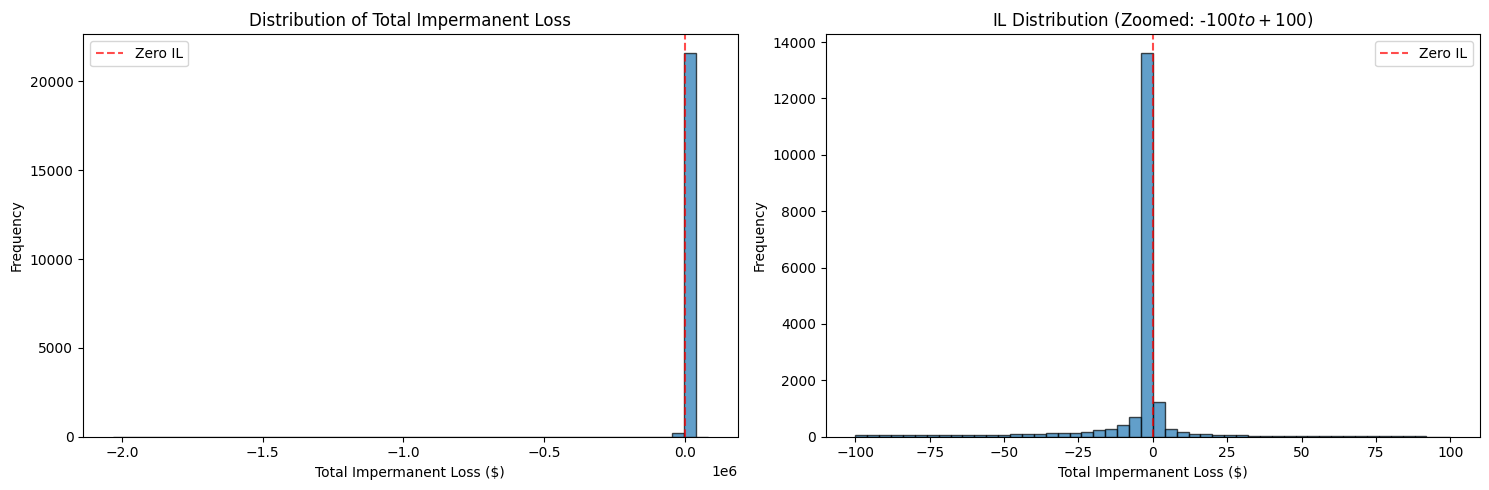

In [37]:
import matplotlib.pyplot as plt

# Create histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of all IL values
ax1.hist(il_metrics_df['total_impermanent_loss'], bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Total Impermanent Loss ($)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Total Impermanent Loss')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero IL')
ax1.legend()

# Zoom in on the range around zero
il_filtered = il_metrics_df['total_impermanent_loss']
il_range = il_filtered[(il_filtered >= -100) & (il_filtered <= 100)]
ax2.hist(il_range, bins=50, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Total Impermanent Loss ($)')
ax2.set_ylabel('Frequency')
ax2.set_title('IL Distribution (Zoomed: -$100 to +$100)')
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero IL')
ax2.legend()

plt.tight_layout()
plt.show()

Found 9149 unique (LP, FPMM) pairs
Processed 200/9149 pairs...
Processed 400/9149 pairs...
Processed 600/9149 pairs...
Processed 800/9149 pairs...
Processed 1000/9149 pairs...
Processed 1200/9149 pairs...
Processed 1400/9149 pairs...
Processed 1600/9149 pairs...
Processed 1800/9149 pairs...
Processed 2000/9149 pairs...
Processed 2200/9149 pairs...
Processed 2400/9149 pairs...
Processed 2600/9149 pairs...
Processed 2800/9149 pairs...
Processed 3000/9149 pairs...
Processed 3200/9149 pairs...
Processed 3400/9149 pairs...
Processed 3600/9149 pairs...
Processed 3800/9149 pairs...
Processed 4000/9149 pairs...
Processed 4200/9149 pairs...
Processed 4400/9149 pairs...
Processed 4600/9149 pairs...
Processed 4800/9149 pairs...
Processed 5000/9149 pairs...
Processed 5200/9149 pairs...
Processed 5400/9149 pairs...
Processed 5600/9149 pairs...
Processed 5800/9149 pairs...
Processed 6000/9149 pairs...
Processed 6200/9149 pairs...
Processed 6400/9149 pairs...
Processed 6600/9149 pairs...
Processed 68

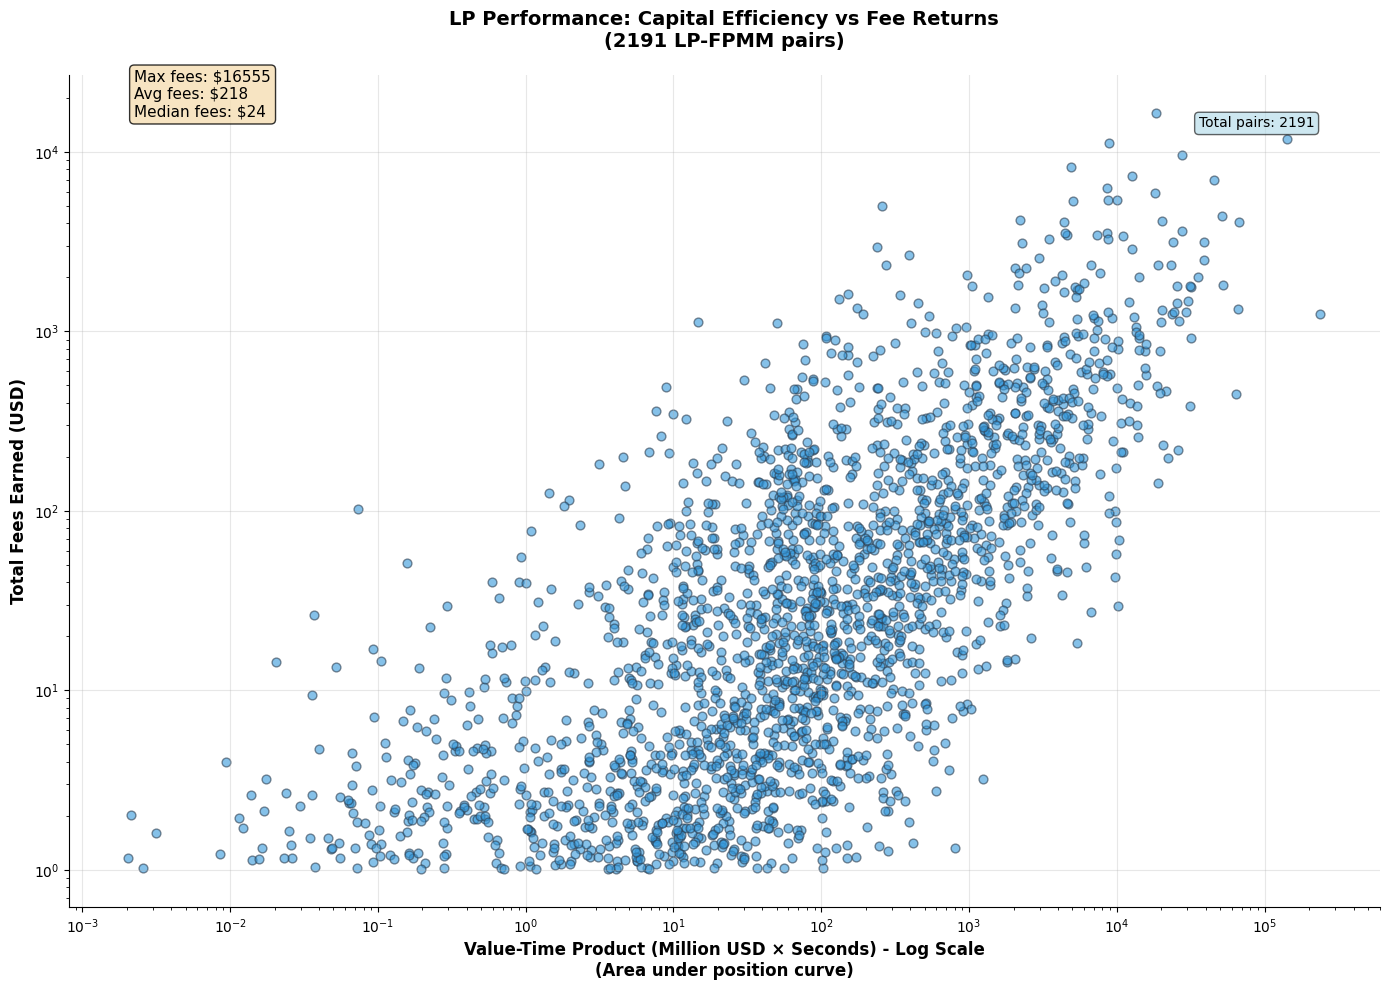


Top 10 performers by total fees:
  a82d4422_c74fe4d9: $16555 fees, 18368.5M USD⋅sec
  d5cebf3c_3409171d: $11764 fees, 142392.2M USD⋅sec
  a4676177_635936a6: $11199 fees, 8858.3M USD⋅sec
  00a66f1f_c74fe4d9: $9606 fees, 27593.4M USD⋅sec
  f9555724_f804eae6: $8198 fees, 4906.4M USD⋅sec
  c942a0fe_2d38aad1: $7344 fees, 12672.6M USD⋅sec
  90b7aa8b_4b4714d2: $6932 fees, 45201.3M USD⋅sec
  d7deafb5_940ae9b6: $6255 fees, 8563.7M USD⋅sec
  d5cebf3c_635936a6: $5905 fees, 18128.3M USD⋅sec
  c942a0fe_d43ea349: $5417 fees, 10071.0M USD⋅sec

Top 10 most capital efficient (highest fees per unit of capital-time):
  31ddac0b_c74fe4d9: $102 fees, 1395.34 $/M USD⋅sec
  6db47552_b31d7746: $2 fees, 949.55 $/M USD⋅sec
  20118a15_773cc028: $26 fees, 706.88 $/M USD⋅sec
  f1d0f47d_2b2d0284: $14 fees, 705.37 $/M USD⋅sec
  8c338717_403cb01a: $1 fees, 568.03 $/M USD⋅sec
  0dfa7cd0_6a21498e: $2 fees, 507.28 $/M USD⋅sec
  05150d39_9f498c86: $4 fees, 428.20 $/M USD⋅sec
  d65f6da5_245e65ac: $1 fees, 399.16 $/M USD⋅

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_lp_metrics(filtered_df):
    """Calculate area under curve (value * duration) and total fees for an FPMM"""
    timeline = []
    
    # Process funding events only (and only before resolution if resolution data exists)
    funding_events = filtered_df[filtered_df['type'].isin(['FundingAdded', 'FundingRemoved'])].sort_values('timestamp_dt')
    
    # Filter out events after resolution
    if 'resolution_timestamp' in filtered_df.columns:
        funding_events = funding_events[funding_events['timestamp'] <= funding_events['resolution_timestamp']]
    
    if len(funding_events) == 0:
        return 0, 0, 0  # No events
    
    lp_token_holdings = [0, 0]
    total_locked = 0.0
    total_fees = 0.0
    value_time_product = 0.0  # This will be our area under the curve
    
    previous_timestamp = None
    previous_value = 0.0
    
    for _, event in funding_events.iterrows():
        # Get token prices from price column
        if event['price'] and len(event['price']) >= 2:
            prices = event['price']
        else:
            continue  # Skip events without price data
        
        current_timestamp = event['timestamp_dt']
        
        # Calculate area for the previous time period
        if previous_timestamp is not None:
            duration_seconds = (current_timestamp - previous_timestamp).total_seconds()
            value_time_product += previous_value * duration_seconds  # USD * seconds
        
        if event['type'] == 'FundingAdded':
            # Add tokens from this transaction
            tokens_added = [0, 0]
            for i in range(len(lp_token_holdings)):
                tokens_added[i] = event['quantity'][i] 
                lp_token_holdings[i] += tokens_added[i]
            
            # Calculate position value added
            position_added = sum(tokens_added[i] * prices[i] for i in range(len(tokens_added))) / 1e6
            total_locked += position_added
            
        elif event['type'] == 'FundingRemoved':
            fee_earned = event['amount']
            total_fees += fee_earned
            
            # Calculate value of tokens removed
            if event['quantity'] and len(event['quantity']) >= 2:
                tokens_removed = event['quantity']
                value_removed = sum((tokens_removed[i] * prices[i]) / 1e6 for i in range(len(tokens_removed)))
                
                # Update LP holdings
                for i in range(len(lp_token_holdings)):
                    lp_token_holdings[i] -= tokens_removed[i]
                
                total_locked -= value_removed
        
        # Update for next iteration
        previous_timestamp = current_timestamp
        previous_value = total_locked
        
        timeline.append({
            'timestamp': current_timestamp,
            'position_value': total_locked,
            'event_type': event['type']
        })
    
    # Calculate total duration from first to last event
    if len(timeline) > 1:
        total_duration_seconds = (timeline[-1]['timestamp'] - timeline[0]['timestamp']).total_seconds()
    else:
        total_duration_seconds = 0
    
    return value_time_product, total_fees, total_duration_seconds

def analyze_all_lp_fpmm_pairs(df):
    """Analyze all (lp, fpmm) pairs and return cost function vs fees data"""
    results = []
    
    # Get all unique (lp, fpmm) combinations - using correct column names
    lp_fpmm_pairs = df[['lp', 'fpmm']].drop_duplicates()  # Limit to 1000 pairs for performance
    
    print(f"Found {len(lp_fpmm_pairs)} unique (LP, FPMM) pairs")
    
    for idx, (_, row) in enumerate(lp_fpmm_pairs.iterrows()):
        lp_address = row['lp']
        fpmm_address = row['fpmm']
        
        # Filter data for this specific (lp, fpmm) pair
        pair_df = df[(df['lp'] == lp_address) & (df['fpmm'] == fpmm_address)]
        
        value_time_product, total_fees, duration_seconds = calculate_lp_metrics(pair_df)
        
        if value_time_product > 0 and total_fees > 1:  # Only include meaningful data
            results.append({
                'lp_address': lp_address,
                'fpmm_address': fpmm_address,
                'pair_id': f"{lp_address[-8:]}_{fpmm_address[-8:]}",  # Short identifier
                'value_time_product': value_time_product,
                'total_fees': total_fees,
                'duration_seconds': duration_seconds,
                'avg_value_locked': value_time_product / duration_seconds if duration_seconds > 0 else 0
            })
        
        # Progress indicator
        if (idx + 1) % 200 == 0:
            print(f"Processed {idx + 1}/{len(lp_fpmm_pairs)} pairs...")
    
    print(f"Analysis complete! Found {len(results)} pairs with meaningful data.")
    return pd.DataFrame(results)

def plot_value_time_vs_fees(results_df):
    """Plot the correlation between value-time product and total fees"""
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Use actual values instead of normalized for better understanding
    value_time_values = results_df['value_time_product'] / 1e6  # Convert to millions for readability
    
    # Create scatter plot with smaller dots and some transparency due to potentially many points
    scatter = ax.scatter(value_time_values, results_df['total_fees'], 
                        s=40, alpha=0.6, color='#3498DB', edgecolors='#2C3E50', linewidth=1)
    
    # Set log scale on x-axis
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('Value-Time Product (Million USD × Seconds) - Log Scale\n(Area under position curve)', 
                  fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Fees Earned (USD)', fontsize=12, fontweight='bold')
    ax.set_title(f'LP Performance: Capital Efficiency vs Fee Returns\n({len(results_df)} LP-FPMM pairs)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Add fee statistics
    max_fee = results_df['total_fees'].max()
    avg_fee = results_df['total_fees'].mean()
    median_fee = results_df['total_fees'].median()
    
    ax.text(0.05, 0.95, f'Max fees: ${max_fee:.0f}\nAvg fees: ${avg_fee:.0f}\nMedian fees: ${median_fee:.0f}', 
            transform=ax.transAxes, fontsize=11, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Add summary statistics (total pairs only)
    ax.text(0.95, 0.95, f'Total pairs: {len(results_df)}', 
            transform=ax.transAxes, fontsize=10, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.6))
    
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()

    # Save as SVG
    
    plt.savefig('amm_lp_cash_efficiency_analysis.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.savefig('amm_lp_cash_efficiency_analysis.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return results_df

df_copy = df.copy()
df_copy = df_copy[df_copy['fee'] == 0.02]
# Analyze all (lp, fpmm) pairs
results_df = analyze_all_lp_fpmm_pairs(df_copy)

# Plot results
results_df = plot_value_time_vs_fees(results_df)

print(f"\nTop 10 performers by total fees:")
top_performers = results_df.nlargest(10, 'total_fees')[['pair_id', 'total_fees', 'value_time_product']]
for _, row in top_performers.iterrows():
    print(f"  {row['pair_id']}: ${row['total_fees']:.0f} fees, {row['value_time_product']/1e6:.1f}M USD⋅sec")

print(f"\nTop 10 most capital efficient (highest fees per unit of capital-time):")
results_df['efficiency'] = results_df['total_fees'] / (results_df['value_time_product'] / 1e6)
top_efficient = results_df.nlargest(10, 'efficiency')[['pair_id', 'total_fees', 'efficiency']]
for _, row in top_efficient.iterrows():
    print(f"  {row['pair_id']}: ${row['total_fees']:.0f} fees, {row['efficiency']:.2f} $/M USD⋅sec")

Found 2324 unique FPMMs
Processed 50/2324 FPMMs...
Processed 100/2324 FPMMs...
Processed 150/2324 FPMMs...
Processed 200/2324 FPMMs...
Processed 250/2324 FPMMs...
Processed 300/2324 FPMMs...
Processed 350/2324 FPMMs...
Processed 400/2324 FPMMs...
Processed 450/2324 FPMMs...
Processed 500/2324 FPMMs...
Processed 550/2324 FPMMs...
Processed 600/2324 FPMMs...
Processed 650/2324 FPMMs...
Processed 700/2324 FPMMs...
Processed 750/2324 FPMMs...
Processed 800/2324 FPMMs...
Processed 850/2324 FPMMs...
Processed 900/2324 FPMMs...
Processed 950/2324 FPMMs...
Processed 1000/2324 FPMMs...
Processed 1050/2324 FPMMs...
Processed 1100/2324 FPMMs...
Processed 1150/2324 FPMMs...
Processed 1200/2324 FPMMs...
Processed 1250/2324 FPMMs...
Processed 1300/2324 FPMMs...
Processed 1350/2324 FPMMs...
Processed 1400/2324 FPMMs...
Processed 1450/2324 FPMMs...
Processed 1500/2324 FPMMs...
Processed 1550/2324 FPMMs...
Processed 1600/2324 FPMMs...
Processed 1650/2324 FPMMs...
Processed 1700/2324 FPMMs...
Processed 

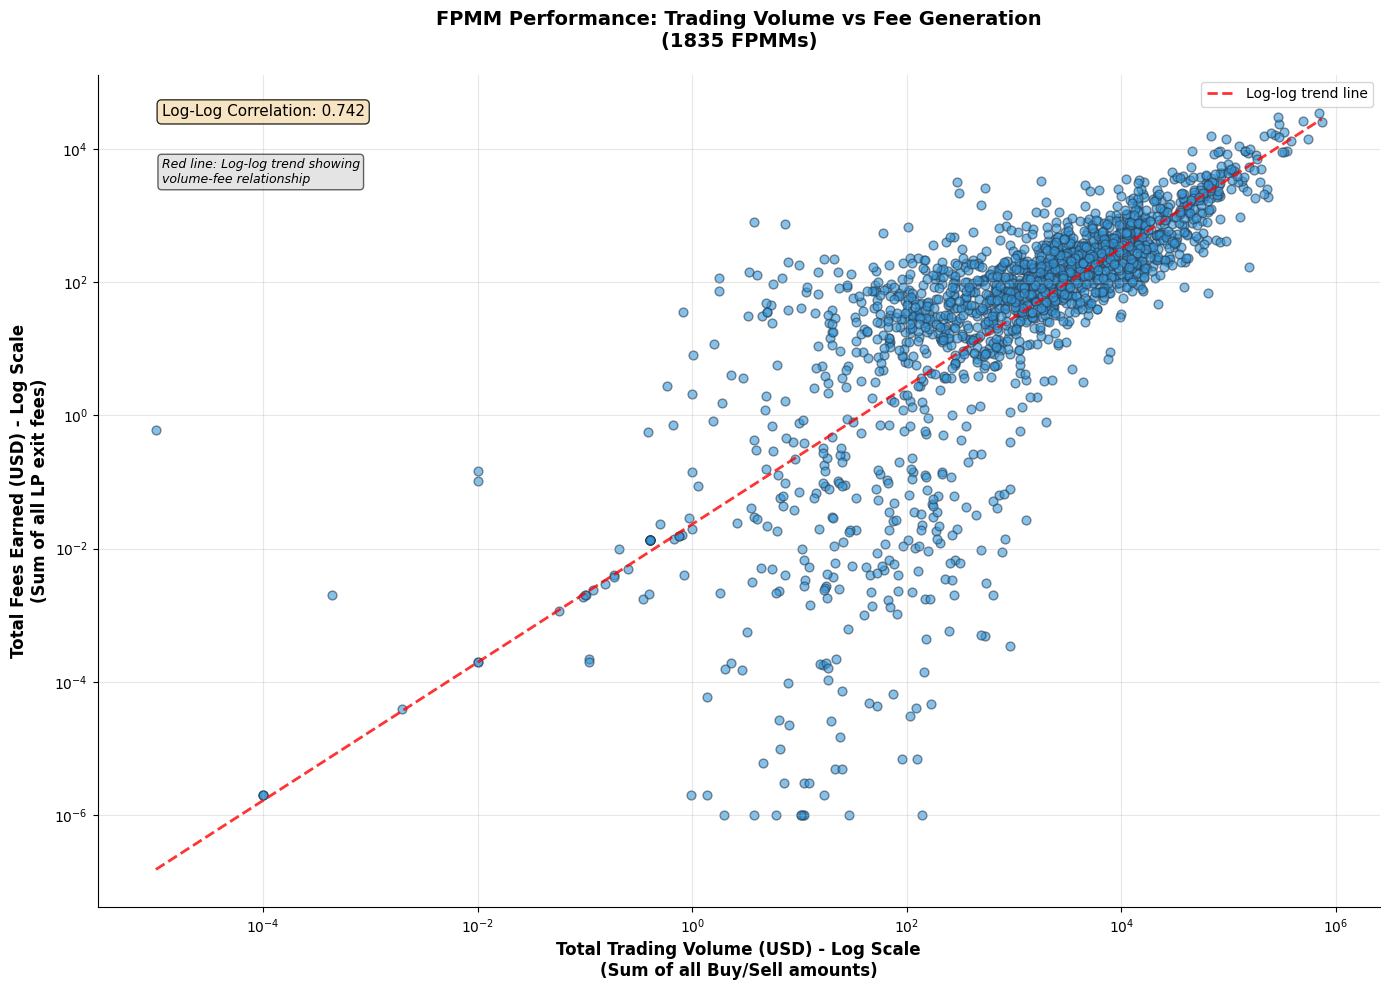


Correlation between trading volume and fees: 0.742

Top 10 FPMMs by trading volume:
  3409171d: $739,360 volume, $24756 fees, 3.35% rate
  635936a6: $697,061 volume, $34791 fees, 4.99% rate
  d0ae0973: $553,237 volume, $13810 fees, 2.50% rate
  f5fc1d4c: $491,887 volume, $25735 fees, 5.23% rate
  4b4714d2: $383,081 volume, $13112 fees, 3.42% rate
  f3012612: $347,611 volume, $9378 fees, 2.70% rate
  f804eae6: $331,347 volume, $17599 fees, 5.31% rate
  4049b879: $330,733 volume, $8953 fees, 2.71% rate
  c12202a0: $315,630 volume, $8997 fees, 2.85% rate
  cebeed22: $298,575 volume, $23376 fees, 7.83% rate

Top 10 FPMMs by total fees:
  635936a6: $697,061 volume, $34791 fees, 4.99% rate
  c74fe4d9: $290,077 volume, $30331 fees, 10.46% rate
  f5fc1d4c: $491,887 volume, $25735 fees, 5.23% rate
  3409171d: $739,360 volume, $24756 fees, 3.35% rate
  cebeed22: $298,575 volume, $23376 fees, 7.83% rate
  f804eae6: $331,347 volume, $17599 fees, 5.31% rate
  70e0ef5e: $250,594 volume, $17471 fees

In [18]:
def analyze_volume_vs_fees(df):
    """Analyze trading volume vs total fees for each FPMM"""
    results = []
    
    # Get all unique FPMMs
    fpmms = df['fpmm'].unique()
    
    print(f"Found {len(fpmms)} unique FPMMs")
    
    for idx, fpmm_address in enumerate(fpmms):
        # Filter data for this FPMM
        fpmm_df = df[df['fpmm'] == fpmm_address]
        
        # Calculate total trading volume (sum of buy/sell amounts)
        trading_events = fpmm_df[fpmm_df['type'].isin(['Buy', 'Sell'])]
        total_volume = trading_events['amount'].sum()
        
        # Calculate total fees (sum of funding removed amounts)
        funding_removed_events = fpmm_df[fpmm_df['type'] == 'FundingRemoved']
        total_fees = funding_removed_events['amount'].sum()
        
        # Only include FPMMs with both volume and fees
        if total_volume > 0 and total_fees > 0:
            results.append({
                'fpmm_address': fpmm_address,
                'fpmm_id': fpmm_address[-8:],  # Short identifier
                'total_volume': total_volume,
                'total_fees': total_fees,
                'fee_rate': total_fees / total_volume if total_volume > 0 else 0,
                'num_trades': len(trading_events),
                'num_lp_exits': len(funding_removed_events)
            })
        
        # Progress indicator
        if (idx + 1) % 50 == 0:
            print(f"Processed {idx + 1}/{len(fpmms)} FPMMs...")
    
    print(f"Analysis complete! Found {len(results)} FPMMs with both volume and fees.")
    return pd.DataFrame(results)

def plot_volume_vs_fees(results_df):
    """Plot the correlation between trading volume and total fees"""
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Create scatter plot
    scatter = ax.scatter(results_df['total_volume'], results_df['total_fees'], 
                        s=40, alpha=0.6, color='#3498DB', edgecolors='#2C3E50', linewidth=1)
    
    # Add trend line
    if len(results_df) > 1:
        z = np.polyfit(np.log10(results_df['total_volume']), np.log10(results_df['total_fees']), 1)
        p = np.poly1d(z)
        x_trend = np.logspace(np.log10(results_df['total_volume'].min()), 
                             np.log10(results_df['total_volume'].max()), 100)
        y_trend = 10**(p(np.log10(x_trend)))
        ax.plot(x_trend, y_trend, 
                "r--", alpha=0.8, linewidth=2, label='Log-log trend line')
        ax.legend()
    
    # Set log scale on both axes
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('Total Trading Volume (USD) - Log Scale\n(Sum of all Buy/Sell amounts)', 
                  fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Fees Earned (USD) - Log Scale\n(Sum of all LP exit fees)', 
                  fontsize=12, fontweight='bold')
    ax.set_title(f'FPMM Performance: Trading Volume vs Fee Generation\n({len(results_df)} FPMMs)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Calculate correlation on log scale
    correlation = np.corrcoef(np.log10(results_df['total_volume']), 
                             np.log10(results_df['total_fees']))[0, 1]
    ax.text(0.05, 0.95, f'Log-Log Correlation: {correlation:.3f}', 
            transform=ax.transAxes, fontsize=11, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Add explanation
    ax.text(0.05, 0.87, 'Red line: Log-log trend showing\nvolume-fee relationship', 
            transform=ax.transAxes, fontsize=9, style='italic',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.6))
    
    # Add summary statistics
    avg_fee_rate = results_df['fee_rate'].mean() * 100  # Convert to percentage
    median_fee_rate = results_df['fee_rate'].median() * 100
    
    # ax.text(0.95, 0.95, f'Total FPMMs: {len(results_df)}\nAvg volume: ${results_df["total_volume"].mean():,.0f}\nAvg fee rate: {avg_fee_rate:.2f}%\nMedian fee rate: {median_fee_rate:.2f}%', 
            # transform=ax.transAxes, fontsize=10, ha='right', va='top',
            # bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.6))
    
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('amm_fee_vs_volume_analysis.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    return correlation, results_df

# Run the volume vs fees analysis
volume_results_df = analyze_volume_vs_fees(df)
volume_correlation, volume_results_df = plot_volume_vs_fees(volume_results_df)

print(f"\nCorrelation between trading volume and fees: {volume_correlation:.3f}")
print(f"\nTop 10 FPMMs by trading volume:")
top_volume = volume_results_df.nlargest(10, 'total_volume')[['fpmm_id', 'total_volume', 'total_fees', 'fee_rate']]
for _, row in top_volume.iterrows():
    print(f"  {row['fpmm_id']}: ${row['total_volume']:,.0f} volume, ${row['total_fees']:.0f} fees, {row['fee_rate']*100:.2f}% rate")

print(f"\nTop 10 FPMMs by total fees:")
top_fees = volume_results_df.nlargest(10, 'total_fees')[['fpmm_id', 'total_volume', 'total_fees', 'fee_rate']]
for _, row in top_fees.iterrows():
    print(f"  {row['fpmm_id']}: ${row['total_volume']:,.0f} volume, ${row['total_fees']:.0f} fees, {row['fee_rate']*100:.2f}% rate")

print(f"\nHighest fee rate FPMMs:")
top_rate = volume_results_df.nlargest(10, 'fee_rate')[['fpmm_id', 'total_volume', 'total_fees', 'fee_rate']]
for _, row in top_rate.iterrows():
    print(f"  {row['fpmm_id']}: ${row['total_volume']:,.0f} volume, ${row['total_fees']:.0f} fees, {row['fee_rate']*100:.2f}% rate")

In [77]:
# Timeline for all LPs that were involved in a selected FPMM
selected_fpmm = "0x6489b85356d911d356aa7e88b4a13c88d0ae0973"

# Get all unique LPs involved in this FPMM
lp_list = df[df['fpmm'] == selected_fpmm]['lp'].unique()

print(f"LPs involved in FPMM {selected_fpmm}: {len(lp_list)} unique LPs")

if lp_list.size == 0:
    print(f"No events found for FPMM {selected_fpmm}.")
else:
    for selected_lp in lp_list:
        filtered_df = df[(df['fpmm'] == selected_fpmm) & (df['lp'] == selected_lp)]
        
        if not filtered_df.empty:
            print(f"\nEvents for FPMM {selected_fpmm} and LP {selected_lp}:")

            # Prepare display DataFrame
            display_df = filtered_df.copy()
            display_df['amount'] = display_df['amount'].apply(lambda x: f"${x:,.2f}" if pd.notnull(x) else "")
            display_df['price'] = display_df['price'].apply(format_price_array)
            display_df['quantity'] = display_df['quantity'].apply(format_quantity)
            
            # Select columns including resolution timestamp
            display_columns = ['timestamp_dt', 'resolution_dt', 'type', 'hash', 'amount', 'asset_id', "price", "quantity"]
            display_df = display_df[display_columns]
            
            # Optionally add a synthetic resolution event row for clarity
            resolution_timestamp = filtered_df['resolution_dt'].iloc[0]
            resolution_event = pd.DataFrame([{
                'timestamp_dt': resolution_timestamp,
                'resolution_dt': resolution_timestamp, 
                'type': 'Resolution',
                'hash': '',
                'amount': '',
                'asset_id': '',
                'price': '',
                'quantity': ''
            }])
            
            # Combine and sort
            combined_df = pd.concat([display_df, resolution_event], ignore_index=True)
            combined_df = combined_df.sort_values('timestamp_dt')
            
            print(combined_df.to_string(index=False))
            
            # Calculate and print PnL for this LP
            pnl = (
                filtered_df[filtered_df['type'].isin(['FundingRemoved', 'Sell', 'Redemption', 'Merge'])]['amount'].sum()
                - filtered_df[filtered_df['type'].isin(['FundingAdded', 'Buy', 'Split'])]['amount'].sum() 
                - filtered_df['cpmmFee'].sum()
            )
            print(f"\nPnL for LP {selected_lp} in FPMM {selected_fpmm}: ${pnl:,.2f}")
            
            # total interactions of the selected lp with this fpmm
            total_interactions = filtered_df.shape[0]
            print(f"Total interactions of LP {selected_lp} with FPMM {selected_fpmm}: {total_interactions}")

LPs involved in FPMM 0x6489b85356d911d356aa7e88b4a13c88d0ae0973: 91 unique LPs

Events for FPMM 0x6489b85356d911d356aa7e88b4a13c88d0ae0973 and LP 0x9d84ce0306f8551e02efef1680475fc0f1dc1344:
       timestamp_dt       resolution_dt           type                                                               hash     amount                                                                      asset_id        price                   quantity
2022-04-28 04:14:27 2022-09-05 18:30:54   FundingAdded 0x57c1059ce95f15a32fe2b1fce57de722139eca0826b2ac9474054f5dd84bf9e6  $5,555.00                                                                          USDC [0.31, 0.69]   [5555000000, 2454120526]
2022-04-28 04:15:31 2022-09-05 18:30:54            Buy 0x3d6bd61bac7fac7d8900cbd3986ccd9081591552c86a26c62dda42262f8df411  $1,111.00 50020510440737250328008159708072591412893525445726218563056023860740951051234       [0.72]               [1539899026]
2022-04-28 04:16:03 2022-09-05 18:30:54            Buy 0x

In [ ]:
import plotly.express as px
import numpy as np

if not df.empty:
    # For better visualization, filter to a specific window, e.g., 7 days before and after resolution
    plot_df = df[df['relative_time_hours'].between(-7*24, 7*24)]

    fig = px.scatter(
        plot_df,
        x="relative_time_hours",
        y="amount",
        color="type",
        title="LP Activity Around Market Resolution",
        labels={"relative_time_hours": "Hours Relative to Resolution", "amount": "Transaction Amount (USDC)"},
        hover_data=['fpmm', 'lp'],
        log_y=True,  # Use a log scale to handle a wide range of amounts
        color_discrete_map={
            'FundingAdded': 'green',
            'FundingRemoved': 'red',
            'Buy': 'blue',
            'Sell': 'orange',
            'Redemption': 'purple'
        }
    )

    # Add a vertical line to mark the moment of resolution
    fig.add_vline(x=0, line_width=2, line_dash="dash", line_color="black", annotation_text="Resolution")
    fig.show()
    


In [22]:
import numpy as np
from datetime import datetime
import pandas as pd

def calculate_capital_efficiency(group):
    """Calculate Capital-Time Efficiency for a specific LP-FPMM pair"""
    # Sort by timestamp
    events = group.sort_values('timestamp_dt')
    
    # Calculate total investment and returns
    incoming = events[events['type'].isin(['FundingRemoved', 'Sell', 'Redemption', 'Merge'])]['amount'].sum()
    outgoing = events[events['type'].isin(['FundingAdded', 'Buy', 'Split', 'cpmmFee'])]['amount'].sum() + events['cpmmFee'].sum()
    pnl = incoming - outgoing
    
    # Calculate Value-Time Product (USD * Days)
    value_time_product = 0.0
    current_value_locked = 0.0
    last_timestamp = None
    
    # Get resolution date
    resolution_date = events['resolution_dt'].iloc[0] if pd.notna(events['resolution_dt'].iloc[0]) else None
    
    for _, event in events.iterrows():
        event_timestamp = event['timestamp_dt']
        
        # Add the contribution of the previous period
        if last_timestamp is not None:
            duration_days = (event_timestamp - last_timestamp).total_seconds() / (24 * 3600)
            value_time_product += current_value_locked * duration_days
        
        # Update the current value locked based on the event
        if event['type'] == 'FundingAdded':
            current_value_locked += event['amount']
        elif event['type'] == 'FundingRemoved':
            current_value_locked -= event['amount']
        # For Buy/Sell, the net effect is captured in the amounts, so we don't need to adjust here
        
        last_timestamp = event_timestamp
    
    # Add the final period until resolution
    if last_timestamp is not None and resolution_date is not None:
        final_duration_days = (resolution_date - last_timestamp).total_seconds() / (24 * 3600)
        value_time_product += current_value_locked * final_duration_days
    
    # Calculate efficiency: profit per dollar-day
    efficiency = pnl / value_time_product if value_time_product > 0 else None
    
    # Calculate total days held (from first event to resolution)
    if len(events) > 0 and resolution_date is not None:
        total_days = (resolution_date - events.iloc[0]['timestamp_dt']).total_seconds() / (24 * 3600)
    else:
        total_days = None
    
    return efficiency, value_time_product, total_days, pnl

# Group by FPMM and LP, calculate PnL and Capital Efficiency for each
lp_fpmm_pnl = []
for (fpmm, lp), group in df.groupby(['fpmm', 'lp']):
    incoming = group[group['type'].isin(['FundingRemoved', 'Sell', 'Redemption', 'Merge'])]['amount'].sum()
    outgoing = group[group['type'].isin(['FundingAdded', 'Buy', 'Split', 'cpmmFee'])]['amount'].sum() + group['cpmmFee'].sum()
    pnl = incoming - outgoing
    
    # Calculate Capital Efficiency
    efficiency, value_time_product, total_days, calc_pnl = calculate_capital_efficiency(group)
    
    lp_fpmm_pnl.append({
        'fpmm': fpmm, 
        'lp': lp, 
        'pnl': pnl, 
        'outgoing': outgoing,
        'efficiency_per_dollar_day': efficiency,
        'value_time_product_usd_days': value_time_product,
        'total_days': total_days
    })

lp_fpmm_pnl_df = pd.DataFrame(lp_fpmm_pnl)

# Filter out rows where efficiency couldn't be calculated
valid_efficiency_df = lp_fpmm_pnl_df[lp_fpmm_pnl_df['efficiency_per_dollar_day'].notna()]

# For each LP, calculate stats including average efficiency
lp_stats = []
for lp, group in lp_fpmm_pnl_df.groupby('lp'):
    total_fpmms = group['fpmm'].nunique()
    profitable_fpmms = (group['pnl'] > 0).sum()
    pct_profitable = profitable_fpmms / total_fpmms if total_fpmms > 0 else 0
    total_profit = group['pnl'].sum()
    total_outgoing = group['outgoing'].sum()
    profit_pct = total_profit / total_outgoing if total_outgoing > 0 else 0
    
    # Efficiency calculations (only for valid efficiency entries)
    valid_group = group[group['efficiency_per_dollar_day'].notna()]
    avg_efficiency = valid_group['efficiency_per_dollar_day'].mean() if len(valid_group) > 0 else None
    median_efficiency = valid_group['efficiency_per_dollar_day'].median() if len(valid_group) > 0 else None
    
    lp_stats.append({
        'lp': lp,
        'total_fpmms': total_fpmms,
        'profitable_fpmms': profitable_fpmms,
        'pct_profitable': pct_profitable,
        'total_profit': total_profit,
        'profit_pct': profit_pct,
        'avg_efficiency': avg_efficiency,
        'median_efficiency': median_efficiency,
        'valid_efficiency_count': len(valid_group)
    })

# Top 20 LPs by profitable FPMM percentage (with at least 10 FPMMs for significance)
top_10_profitable = sorted([x for x in lp_stats if x['total_fpmms'] >= 10], key=lambda x: x['pct_profitable'], reverse=True)[:20]

print("\nTop 20 LPs by % of Profitable FPMMs (min 10 FPMMs):")
print(f"{'Rank':<4} {'LP Address':<42} {'Profitable':<15} {'Total Profit($)':<18} {'Profit %':<10} {'Avg Efficiency':<15} {'FPMMs':<6}")
for i, r in enumerate(top_10_profitable, 1):
    avg_efficiency_str = f"{r['avg_efficiency']*1000:>7.3f}‰" if r['avg_efficiency'] is not None else "N/A"
    print(f"{i:<4} {r['lp']:<42} {r['profitable_fpmms']}/{r['total_fpmms']:<13} ${r['total_profit']:>14,.2f}   {r['profit_pct']*100:>7.2f}%   {avg_efficiency_str:<15} {r['total_fpmms']:<6}")

# Also show top LPs by Capital Efficiency
top_by_efficiency = sorted([x for x in lp_stats if x['avg_efficiency'] is not None and x['valid_efficiency_count'] >= 5], 
                          key=lambda x: x['avg_efficiency'], reverse=True)[:20]

print(f"\nTop 20 LPs by Average Capital Efficiency (min 5 resolved FPMMs):")
print(f"{'Rank':<4} {'LP Address':<42} {'Avg Efficiency':<15} {'Median Efficiency':<18} {'Resolved':<9} {'Total Profit($)':<15}")
for i, r in enumerate(top_by_efficiency, 1):
    avg_efficiency_str = f"{r['avg_efficiency']*1000:>7.3f}‰"
    median_efficiency_str = f"{r['median_efficiency']*1000:>7.3f}‰" if r['median_efficiency'] is not None else "N/A"
    print(f"{i:<4} {r['lp']:<42} {avg_efficiency_str:<15} {median_efficiency_str:<18} {r['valid_efficiency_count']:<9} ${r['total_profit']:>12,.2f}")

# Show some example interpretations
print(f"\nEfficiency Interpretation Examples:")
print(f"0.001 = $1 profit per $1,000 invested for 1 day")
print(f"0.010 = $10 profit per $1,000 invested for 1 day") 
print(f"Values shown in per-mille (‰) for readability")


Top 20 LPs by % of Profitable FPMMs (min 10 FPMMs):
Rank LP Address                                 Profitable      Total Profit($)    Profit %   Avg Efficiency  FPMMs 
1    0xd8edcc738c3f88f062fb2ddedfe77c5f31026f19 21/21            $      2,335.34      1.48%   102.980‰        21    
2    0x76abc4deb4376bdd94f130316efe8e7483ed60f6 15/16            $      2,479.48      2.09%    10.218‰        16    
3    0x566dc5604f41a1f4f49bacdfd6b03412b3e3f0c9 11/12            $      1,507.70      1.99%    43.513‰        12    
4    0x29f638b0d084a7a54200dcb0ee5ffdcd12b9906b 87/98            $     13,739.88      0.47%    38.433‰        98    
5    0x88186ddbea78ab3d65b7d08f0658b9c22037f265 19/22            $      1,977.34      0.84%   445.565‰        22    
6    0x0c37d01820dae8e51be92f1b82f5eef5f544b228 69/81            $         57.31      0.05%   -42.275‰        81    
7    0x0211d17733851605309e400aa4c62991d41cd013 10/12            $     -6,841.09    -17.79%     1.346‰        12    
8    0xe297

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_88548/4117855823.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax2.boxplot(entry_prices_by_lp, labels=lp_names, patch_artist=True)


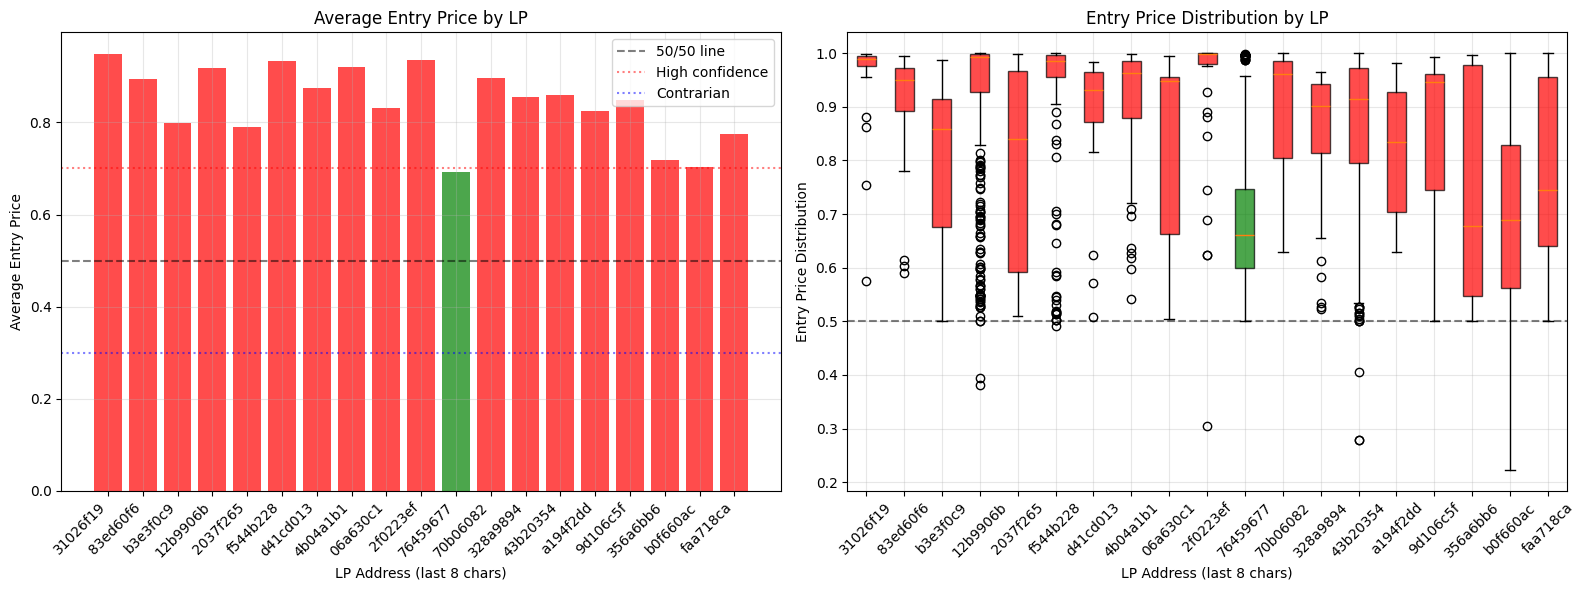


LP Entry Behavior Summary:
LP         Avg Price  Entries  Strategy                 
-------------------------------------------------------
31026f19   0.948      22       High Confidence          
83ed60f6   0.894      23       High Confidence          
b3e3f0c9   0.798      26       High Confidence          
12b9906b   0.919      410      High Confidence          
2037f265   0.790      60       High Confidence          
f544b228   0.934      210      High Confidence          
d41cd013   0.876      21       High Confidence          
4b04a1b1   0.921      114      High Confidence          
06a630c1   0.831      17       High Confidence          
2f0223ef   0.935      39       High Confidence          
76459677   0.693      214      Mixed                    
70b06082   0.897      26       High Confidence          
328a9894   0.855      53       High Confidence          
43b20354   0.860      366      High Confidence          
a194f2dd   0.824      39       High Confidence          
9d10

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# List of target LPs (fixed the missing comma)
target_lps = [
    '0xd8edcc738c3f88f062fb2ddedfe77c5f31026f19',
    '0x76abc4deb4376bdd94f130316efe8e7483ed60f6',
    '0x566dc5604f41a1f4f49bacdfd6b03412b3e3f0c9',
    '0x29f638b0d084a7a54200dcb0ee5ffdcd12b9906b',
    '0x88186ddbea78ab3d65b7d08f0658b9c22037f265',
    '0x0c37d01820dae8e51be92f1b82f5eef5f544b228',
    '0x0211d17733851605309e400aa4c62991d41cd013',
    '0xe2971abfbecad7a6155f19fe57bd7d0d4b04a1b1',
    '0x40bd8cba0b55e4dfdfaa8b708c0baeae06a630c1',
    '0xfc12bd975d6cc359b43d13967ee3c06c2f0223ef',
    '0xca310c89f98430bdd6540020bfaf3c6676459677',
    '0x37ea663f38ffc6e0bf5793a140cb62a970b06082',
    '0x8016502332a54f42608d7e12549dbc82328a9894',
    '0xae50d6935c736696a99c309a4dcabe1343b20354',
    '0x699c655504b0553a120c436d42b873b4a194f2dd',
    '0xb342a95cac696d82426533a1765b823d9d106c5f',
    '0x6addb6266629cddf6eb42ee6ac3fbfc9356a6bb6',
    '0x63f8eb9f5f902f6637f75f10fc185e77b0f660ac',
    '0x1eedb4a031ce6f4a0e23873f631d294ffaa718ca'
]

def analyze_lp_entry_prices(target_lp):
    """Analyze the market prices when LP adds funding"""
    funding_events = df[(df['lp'] == target_lp) & (df['type'] == 'FundingAdded')]
    
    if funding_events.empty:
        return None
    
    entry_prices = []
    for _, event in funding_events.iterrows():
        price_array = event['price']
        if isinstance(price_array, list) and len(price_array) >= 2:
            entry_price = max(price_array)
            entry_prices.append({
                'entry_price': entry_price,
                'amount': event['amount'],
                'timestamp': event['timestamp_dt']
            })
    
    return entry_prices

# Collect data for all LPs
lp_data = []
for target_lp in target_lps:
    entry_data = analyze_lp_entry_prices(target_lp)
    if entry_data:
        entry_prices = [e['entry_price'] for e in entry_data]
        amounts = [e['amount'] for e in entry_data]
        
        avg_entry_price = np.mean(entry_prices)
        total_amount = sum(amounts)
        weighted_avg_price = sum(price * amount for price, amount in zip(entry_prices, amounts)) / total_amount
        price_std = np.std(entry_prices)
        
        lp_data.append({
            'LP': target_lp[-8:],  # Last 8 chars for display
            'Avg_Entry_Price': avg_entry_price,
            'Weighted_Avg_Price': weighted_avg_price,
            'Price_Std': price_std,
            'Total_Entries': len(entry_data),
            'Total_Amount': total_amount,
            'Entry_Prices': entry_prices  # Keep individual prices for distribution
        })

# Create visualizations
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Average Entry Price by LP
lp_names = [d['LP'] for d in lp_data]
avg_prices = [d['Avg_Entry_Price'] for d in lp_data]
colors = ['red' if p > 0.7 else 'blue' if p < 0.3 else 'green' for p in avg_prices]

bars1 = ax1.bar(range(len(lp_names)), avg_prices, color=colors, alpha=0.7)
ax1.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='50/50 line')
ax1.axhline(y=0.7, color='red', linestyle=':', alpha=0.5, label='High confidence')
ax1.axhline(y=0.3, color='blue', linestyle=':', alpha=0.5, label='Contrarian')
ax1.set_xlabel('LP Address (last 8 chars)')
ax1.set_ylabel('Average Entry Price')
ax1.set_title('Average Entry Price by LP')
ax1.set_xticks(range(len(lp_names)))
ax1.set_xticklabels(lp_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Entry Price Distribution (Box Plot)
entry_prices_by_lp = [d['Entry_Prices'] for d in lp_data]
box_plot = ax2.boxplot(entry_prices_by_lp, labels=lp_names, patch_artist=True)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('LP Address (last 8 chars)')
ax2.set_ylabel('Entry Price Distribution')
ax2.set_title('Entry Price Distribution by LP')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Price Volatility vs Number of Entries
# std_devs = [d['Price_Std'] for d in lp_data]
# entry_counts = [d['Total_Entries'] for d in lp_data]
# scatter = ax3.scatter(entry_counts, std_devs, s=100, c=avg_prices, cmap='RdYlBu_r', alpha=0.7)
# ax3.set_xlabel('Number of Funding Events')
# ax3.set_ylabel('Price Standard Deviation')
# ax3.set_title('Entry Consistency vs Activity Level')
# ax3.grid(True, alpha=0.3)
# plt.colorbar(scatter, ax=ax3, label='Avg Entry Price')

# # Add LP labels to scatter plot
# for i, lp in enumerate(lp_names):
#     ax3.annotate(lp, (entry_counts[i], std_devs[i]), xytext=(5, 5), 
#                 textcoords='offset points', fontsize=8, alpha=0.8)

# # 4. Weighted vs Simple Average Entry Price
# weighted_prices = [d['Weighted_Avg_Price'] for d in lp_data]
# ax4.scatter(avg_prices, weighted_prices, s=100, c=colors, alpha=0.7)
# ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Equal weighting line')
# ax4.set_xlabel('Simple Average Entry Price')
# ax4.set_ylabel('Amount-Weighted Average Entry Price')
# ax4.set_title('Simple vs Weighted Average Entry Price')
# ax4.grid(True, alpha=0.3)
# ax4.legend()

# # Add LP labels
# for i, lp in enumerate(lp_names):
#     ax4.annotate(lp, (avg_prices[i], weighted_prices[i]), xytext=(5, 5), 
#                 textcoords='offset points', fontsize=8, alpha=0.8)

plt.tight_layout()
plt.savefig('amm_lp_entry_behavior_analysis.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

# Print simple summary table
print("\nLP Entry Behavior Summary:")
print(f"{'LP':<10} {'Avg Price':<10} {'Entries':<8} {'Strategy':<25}")
print("-" * 55)

for d in lp_data:
    avg_price = d['Avg_Entry_Price']
    if avg_price > 0.7:
        strategy = "High Confidence"
    elif avg_price < 0.3:
        strategy = "Contrarian"
    elif 0.45 <= avg_price <= 0.55:
        strategy = "Balanced"
    else:
        strategy = "Mixed"
    
    print(f"{d['LP']:<10} {avg_price:<10.3f} {d['Total_Entries']:<8} {strategy:<25}")

In [11]:
import pandas as pd
from datetime import datetime

# List of target LPs
target_lps = [
    '0xd8edcc738c3f88f062fb2ddedfe77c5f31026f19',
    '0x76abc4deb4376bdd94f130316efe8e7483ed60f6', 
    '0x566dc5604f41a1f4f49bacdfd6b03412b3e3f0c9',
    '0x29f638b0d084a7a54200dcb0ee5ffdcd12b9906b',
    '0x88186ddbea78ab3d65b7d08f0658b9c22037f265',
    '0x0c37d01820dae8e51be92f1b82f5eef5f544b228',
    '0x0211d17733851605309e400aa4c62991d41cd013',
    '0xe2971abfbecad7a6155f19fe57bd7d0d4b04a1b1',
    '0x40bd8cba0b55e4dfdfaa8b708c0baeae06a630c1',
    '0xfc12bd975d6cc359b43d13967ee3c06c2f0223ef'
]

def analyze_lp_activity_patterns(target_lp):
    """Analyze activity patterns for a single LP"""
    
    # Get all FPMMs the LP interacted with (no limit)
    lp_fpmms = df[df['lp'] == target_lp]['fpmm'].unique()
    
    # Prepare data for analysis
    plot_data = []
    
    for i, fpmm_addr in enumerate(lp_fpmms):
        # Get FPMM creation info
        fpmm_doc = fpmms_collection.find_one({"fpmm_address": fpmm_addr})
        
        if fpmm_doc:
            creation_timestamp = fpmm_doc['creation_timestamp']
            creation_date = datetime.fromtimestamp(creation_timestamp)
        else:
            # Fallback if no creation info
            creation_date = df[df['fpmm'] == fpmm_addr]['timestamp_dt'].min() - timedelta(hours=1)
        
        # Filter DataFrame for this FPMM and LP, excluding redemptions
        filtered_df = df[(df['fpmm'] == fpmm_addr) & (df['lp'] == target_lp) & (df['type'] != 'Redemption')]
        
        if not filtered_df.empty:
            resolution_date = filtered_df.iloc[0]['resolution_dt']
            
            # Calculate market duration
            market_duration = (resolution_date - creation_date).total_seconds()
            
            for _, row in filtered_df.iterrows():
                # Calculate relative time as percentage of market lifetime
                time_since_creation = (row['timestamp_dt'] - creation_date).total_seconds()
                relative_time_pct = (time_since_creation / market_duration) * 100 if market_duration > 0 else 0
                
                plot_data.append({
                    'fpmm': fpmm_addr,
                    'fpmm_index': i,
                    'creation_date': creation_date,
                    'resolution_date': resolution_date,
                    'activity_date': row['timestamp_dt'],
                    'relative_time_pct': relative_time_pct,
                    'type': row['type'],
                    'amount': row['amount'] if pd.notnull(row['amount']) else 0,
                    'market_duration_days': market_duration / (24 * 3600)
                })
    
    if not plot_data:
        return None
        
    plot_df = pd.DataFrame(plot_data)
    
    # Activity distribution by market phase
    phase_bins = [0, 25, 50, 75, 100]
    phase_labels = ['Early (0-25%)', 'Mid-Early (25-50%)', 'Mid-Late (50-75%)', 'Late (75-100%)']
    plot_df['phase'] = pd.cut(plot_df['relative_time_pct'], bins=phase_bins, labels=phase_labels, include_lowest=True)
    
    return plot_df

# Analyze all LPs
all_lp_results = {}

for target_lp in target_lps:
    print(f"\n{'='*80}")
    print(f"LP Activity Analysis for {target_lp}")
    print(f"{'='*80}")
    
    result_df = analyze_lp_activity_patterns(target_lp)
    
    if result_df is None or result_df.empty:
        print("No activity data found for this LP")
        continue
    
    all_lp_results[target_lp] = result_df
    
    # Get all FPMMs count
    total_fpmms = len(result_df['fpmm'].unique())
    total_activities = len(result_df)
    
    print(f"Total FPMMs: {total_fpmms}")
    print(f"Total activities (excluding redemptions): {total_activities}")
    
    # Activity distribution by market phase
    print(f"\n--- Activity Distribution by Market Phase ---")
    phase_summary = result_df.groupby(['phase', 'type']).size().unstack(fill_value=0)
    print(phase_summary)
    
    # Phase percentages
    print(f"\n--- Activity by Phase (Percentages) ---")
    phase_pct = result_df['phase'].value_counts(normalize=True).sort_index() * 100
    for phase, pct in phase_pct.items():
        print(f"{phase}: {pct:.1f}%")
    
    # Activity type summary
    print(f"\n--- Activity Type Summary ---")
    type_summary = result_df['type'].value_counts()
    print(type_summary)
    
    # Market duration summary
    print(f"\n--- Market Duration Summary ---")
    duration_summary = result_df.groupby('fpmm')['market_duration_days'].first()
    print(f"Average market duration: {duration_summary.mean():.1f} days")
    print(f"Shortest market: {duration_summary.min():.1f} days")
    print(f"Longest market: {duration_summary.max():.1f} days")
    
    # Timing patterns
    print(f"\n--- Timing Patterns ---")
    avg_timing_by_type = result_df.groupby('type')['relative_time_pct'].agg(['mean', 'median', 'std'])
    print("Average timing by activity type (% of market lifetime):")
    print(avg_timing_by_type.round(1))

# Summary comparison across all LPs
print(f"\n{'='*80}")
print("SUMMARY COMPARISON ACROSS ALL LPs")
print(f"{'='*80}")

summary_data = []
for lp, result_df in all_lp_results.items():
    if result_df is not None and not result_df.empty:
        phase_pct = result_df['phase'].value_counts(normalize=True).sort_index() * 100
        
        summary_data.append({
            'LP': lp[:10] + '...',
            'Total_FPMMs': len(result_df['fpmm'].unique()),
            'Total_Activities': len(result_df),
            'Early_Pct': phase_pct.get('Early (0-25%)', 0),
            'Mid_Early_Pct': phase_pct.get('Mid-Early (25-50%)', 0),
            'Mid_Late_Pct': phase_pct.get('Mid-Late (50-75%)', 0),
            'Late_Pct': phase_pct.get('Late (75-100%)', 0),
            'Avg_Market_Duration': result_df.groupby('fpmm')['market_duration_days'].first().mean(),
            'Most_Common_Activity': result_df['type'].value_counts().index[0],
            'Funding_Activities': len(result_df[result_df['type'].isin(['FundingAdded', 'FundingRemoved'])]),
            'Trading_Activities': len(result_df[result_df['type'].isin(['Buy', 'Sell'])])
        })

summary_df = pd.DataFrame(summary_data)
print("\nLP Behavior Summary:")
print(summary_df.round(1).to_string(index=False))

# Identify LP archetypes
print(f"\n--- LP Archetypes ---")
for _, row in summary_df.iterrows():
    lp_short = row['LP']
    
    # Determine archetype based on activity patterns
    if row['Early_Pct'] > 50:
        archetype = "Early Bird (>50% activity in first 25%)"
    elif row['Late_Pct'] > 50:
        archetype = "Late Trader (>50% activity in last 25%)"
    elif row['Mid_Early_Pct'] + row['Mid_Late_Pct'] > 70:
        archetype = "Mid-Market Trader (active in middle phases)"
    elif row['Funding_Activities'] > row['Trading_Activities'] * 2:
        archetype = "Liquidity Provider (mostly funding activities)"
    elif row['Trading_Activities'] > row['Funding_Activities'] * 2:
        archetype = "Active Trader (mostly buy/sell)"
    else:
        archetype = "Balanced Participant"
    
    print(f"{lp_short}: {archetype}")


LP Activity Analysis for 0xd8edcc738c3f88f062fb2ddedfe77c5f31026f19
Total FPMMs: 21
Total activities (excluding redemptions): 89

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell  Split
phase                                                                    
Early (0-25%)         0             0               0      0     1      1
Mid-Early (25-50%)    1             3               0      0     5      1
Mid-Late (50-75%)     1             4               2      0     6      0
Late (75-100%)       11            15               1      5    32      0

--- Activity by Phase (Percentages) ---
Early (0-25%): 2.2%
Mid-Early (25-50%): 11.2%
Mid-Late (50-75%): 14.6%
Late (75-100%): 71.9%

--- Activity Type Summary ---
type
Sell              44
FundingAdded      22
Buy               13
Merge              5
FundingRemoved     3
Split              2
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration:

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 16
Total activities (excluding redemptions): 219

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell
phase                                                             
Early (0-25%)         5             0               0      0     0
Mid-Early (25-50%)    1             6               2      1    17
Mid-Late (50-75%)    10             3               1      3    13
Late (75-100%)       56            14              10     21    56

--- Activity by Phase (Percentages) ---
Early (0-25%): 2.3%
Mid-Early (25-50%): 12.3%
Mid-Late (50-75%): 13.7%
Late (75-100%): 71.7%

--- Activity Type Summary ---
type
Sell              86
Buy               72
Merge             25
FundingAdded      23
FundingRemoved    13
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 64.0 days
Shortest market: 2.3 days
Longest market: 301.6 days

--- Timing Patterns ---
Average timing by activity type (% of mark

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 12
Total activities (excluding redemptions): 419

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell
phase                                                             
Early (0-25%)        42             4               0     10     6
Mid-Early (25-50%)   81             5               1      2    39
Mid-Late (50-75%)    42             6               2      6    51
Late (75-100%)       43            11               1     14    53

--- Activity by Phase (Percentages) ---
Early (0-25%): 14.8%
Mid-Early (25-50%): 30.5%
Mid-Late (50-75%): 25.5%
Late (75-100%): 29.1%

--- Activity Type Summary ---
type
Buy               208
Sell              149
Merge              32
FundingAdded       26
FundingRemoved      4
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 25.0 days
Shortest market: 0.8 days
Longest market: 106.0 days

--- Timing Patterns ---
Average timing by activity type (% o

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 98
Total activities (excluding redemptions): 1398

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell  Split
phase                                                                    
Early (0-25%)         7            19               1      4    22      0
Mid-Early (25-50%)   31            51              14     15    95      0
Mid-Late (50-75%)    30            58              10     25    84      2
Late (75-100%)      116           279              71     65   393      0

--- Activity by Phase (Percentages) ---
Early (0-25%): 3.8%
Mid-Early (25-50%): 14.8%
Mid-Late (50-75%): 15.0%
Late (75-100%): 66.4%

--- Activity Type Summary ---
type
Sell              595
FundingAdded      410
Buy               184
Merge             109
FundingRemoved     98
Split               2
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 13.9 days
Shortest market: 0.7 days
Longest market: 184.1 da

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 22
Total activities (excluding redemptions): 796

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell  Split
phase                                                                    
Early (0-25%)         0             0               0      0     0      1
Mid-Early (25-50%)   68            14              10      1   126      3
Mid-Late (50-75%)    35            17               8      4    83      4
Late (75-100%)      127            29              10      6   238      9

--- Activity by Phase (Percentages) ---
Early (0-25%): 0.1%
Mid-Early (25-50%): 28.0%
Mid-Late (50-75%): 19.0%
Late (75-100%): 52.8%

--- Activity Type Summary ---
type
Sell              447
Buy               230
FundingAdded       60
FundingRemoved     31
Split              17
Merge              11
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 29.0 days
Shortest market: 0.3 days
Longest market: 223.0 day

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 81
Total activities (excluding redemptions): 694

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell
phase                                                             
Early (0-25%)         8            15               1      3    23
Mid-Early (25-50%)   12            26               3      8    25
Mid-Late (50-75%)    28            53               9     27    50
Late (75-100%)       43           116              39     49   155

--- Activity by Phase (Percentages) ---
Early (0-25%): 7.2%
Mid-Early (25-50%): 10.7%
Mid-Late (50-75%): 24.1%
Late (75-100%): 58.0%

--- Activity Type Summary ---
type
Sell              254
FundingAdded      210
Buy                91
Merge              87
FundingRemoved     52
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 29.8 days
Shortest market: 1.0 days
Longest market: 178.0 days

--- Timing Patterns ---
Average timing by activity type (% of

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 12
Total activities (excluding redemptions): 79

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell
phase                                                             
Early (0-25%)         3             4               0      0     3
Mid-Early (25-50%)    2             4               3      3     6
Mid-Late (50-75%)     4             9              13      0    13
Late (75-100%)        1             4               0      0     7

--- Activity by Phase (Percentages) ---
Early (0-25%): 12.7%
Mid-Early (25-50%): 22.8%
Mid-Late (50-75%): 49.4%
Late (75-100%): 15.2%

--- Activity Type Summary ---
type
Sell              29
FundingAdded      21
FundingRemoved    16
Buy               10
Merge              3
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 67.6 days
Shortest market: 7.0 days
Longest market: 184.1 days

--- Timing Patterns ---
Average timing by activity type (% of mark

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 18
Total activities (excluding redemptions): 553

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell  Split
phase                                                                    
Early (0-25%)        39            16               2     12    18      1
Mid-Early (25-50%)   39            17               5     13    36      0
Mid-Late (50-75%)    23            28              11      8    35      0
Late (75-100%)       60            53              29     29    78      0

--- Activity by Phase (Percentages) ---
Early (0-25%): 15.9%
Mid-Early (25-50%): 19.9%
Mid-Late (50-75%): 19.0%
Late (75-100%): 45.1%

--- Activity Type Summary ---
type
Sell              167
Buy               161
FundingAdded      114
Merge              62
FundingRemoved     48
Split               1
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 51.3 days
Shortest market: 3.9 days
Longest market: 126.5 da

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 11
Total activities (excluding redemptions): 123

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Sell
phase                                                      
Early (0-25%)         6             1               0     5
Mid-Early (25-50%)    9             5               2    26
Mid-Late (50-75%)     4             3               0    12
Late (75-100%)       19             8               2    21

--- Activity by Phase (Percentages) ---
Early (0-25%): 9.8%
Mid-Early (25-50%): 34.1%
Mid-Late (50-75%): 15.4%
Late (75-100%): 40.7%

--- Activity Type Summary ---
type
Sell              64
Buy               38
FundingAdded      17
FundingRemoved     4
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 11.3 days
Shortest market: 0.8 days
Longest market: 29.2 days

--- Timing Patterns ---
Average timing by activity type (% of market lifetime):
                mean  median   std
type           

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Total FPMMs: 11
Total activities (excluding redemptions): 97

--- Activity Distribution by Market Phase ---
type                Buy  FundingAdded  FundingRemoved  Merge  Sell
phase                                                             
Early (0-25%)         5             5               4      4     8
Mid-Early (25-50%)    0             1               1      1     6
Mid-Late (50-75%)     0             2               1      1     5
Late (75-100%)        0             3               0      1     6

--- Activity by Phase (Percentages) ---
Early (0-25%): 48.1%
Mid-Early (25-50%): 16.7%
Mid-Late (50-75%): 16.7%
Late (75-100%): 18.5%

--- Activity Type Summary ---
type
FundingAdded      39
Sell              38
FundingRemoved     8
Merge              7
Buy                5
Name: count, dtype: int64

--- Market Duration Summary ---
Average market duration: 35.4 days
Shortest market: 6.1 days
Longest market: 92.0 days

--- Timing Patterns ---
Average timing by activity type (% of marke

/var/folders/m3/kqqrjhzd1d737q18g2lzmlwr0000gn/T/ipykernel_9752/1034881514.py:101: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
import pandas as pd
import plotly.express as px

# Ensure the required DataFrames exist
if 'df' not in locals() or 'pnl_pivot' not in locals():
    print("Please run the Data Preparation (Cell 1) and PnL Calculation (Cell 5) scripts first.")
else:
    # 1. Isolate the last pre-resolution removal for each LP
    pre_resolution_removals = df[(df['type'] == 'FundingRemoved') & (df['relative_time_hours'] < 0)].copy()
    
    if not pre_resolution_removals.empty:
        # Find the timestamp of the last removal for each LP in each market
        last_removal_times = pre_resolution_removals.loc[
            pre_resolution_removals.groupby(['fpmm', 'lp'])['timestamp'].idxmax()
        ]
        
        # Merge this timing information with our main PnL table
        strategy_pnl_df = pd.merge(
            pnl_pivot,
            last_removal_times[['fpmm', 'lp', 'relative_time_hours']],
            on=['fpmm', 'lp'],
            how='left'  # Use a left merge to keep all LPs, even those who didn't remove pre-resolution
        )
        strategy_pnl_df.rename(columns={'relative_time_hours': 'last_removal_hours_before_res'}, inplace=True)

        # 2. Categorize LPs into behavioral groups
        def get_strategy(hours):
            if pd.isna(hours):
                return 'Held Past Resolution'
            elif hours >= -24:
                return 'Removed in Last 24 Hours'
            elif hours >= -168: # 24 * 7
                return 'Removed in Last 1-7 Days'
            else:
                return 'Exited >7 Days Before'

        strategy_pnl_df['strategy'] = strategy_pnl_df['last_removal_hours_before_res'].apply(get_strategy)

        # 3. Calculate PnL statistics for each group
        strategy_summary = strategy_pnl_df.groupby('strategy')['pnl'].agg(
            lp_positions='count',
            mean_pnl='mean',
            median_pnl='median',
            total_pnl='sum'
        ).reset_index()

        print("--- Profitability Analysis by LP Removal Strategy ---")
        print("This table shows the average profit for LPs based on when they removed their liquidity before resolution.")
        print(strategy_summary.to_string(index=False, float_format="$%.2f"))

        # 4. Visualize the distribution of PnL for each strategy
        fig = px.box(
            strategy_pnl_df,
            x='strategy',
            y='pnl',
            color='strategy',
            title='LP Profitability Based on Removal Timing',
            labels={
                'pnl': 'Net PnL (USDC)',
                'strategy': 'LP Strategy'
            },
            category_orders={ # Order the strategies logically
                "strategy": [
                    "Exited >7 Days Before",
                    "Removed in Last 1-7 Days",
                    "Removed in Last 24 Hours",
                    "Held Past Resolution"
                ]
            }
        )
        fig.update_yaxes(range=[strategy_pnl_df['pnl'].quantile(0.05), strategy_pnl_df['pnl'].quantile(0.95)]) # Zoom in on the interquantile range to make the box plots more readable
        fig.add_hline(y=0, line_width=2, line_dash="dash", line_color="black")
        print("\nDisplaying box plot of PnL distribution by strategy...")
        fig.show()

    else:
        print("No pre-resolution funding removal events found to analyze.")


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

if not df.empty:
    # Use the same 7-day window for consistency
    plot_df = df[df['relative_time_hours'].between(-7*24, 7*24)].copy()

    # --- Visualization 1: Faceted Scatter Plot ---
    # This separates each event type into its own subplot to avoid clutter.
    # print("--- Displaying Faceted Scatter Plot ---")
    # fig1 = px.scatter(
    #     plot_df,
    #     x="relative_time_hours",
    #     y="amount",
    #     facet_row="type",  # This is the key change: creates a subplot for each 'type'
    #     title="LP Activity Around Market Resolution (Faceted by Event Type)",
    #     labels={"relative_time_hours": "Hours Relative to Resolution", "amount": "Transaction Amount (USDC)"},
    #     hover_data=['fpmm', 'lp'],
    #     color='type', # Color is still useful for quick identification
    #     color_discrete_map={
    #         'FundingAdded': 'green',
    #         'FundingRemoved': 'red',
    #         'Buy': 'blue',
    #         'Sell': 'orange',
    #         'Redemption': 'purple'
    #     }
    # )
    # # Make the subplots taller and share the x-axis
    # fig1.update_layout(height=1200) 
    # fig1.update_yaxes(matches=None, showticklabels=True) # Give each subplot its own y-axis scale
    # fig1.show()


    # --- Visualization 2: Aggregated Event Volume Plot ---
    # This shows the total volume of activity over time, revealing the flow of capital.
    print("\n--- Displaying Aggregated Event Volume Plot ---")
    
    # Bin the data by hour
    plot_df['time_bin_hours'] = plot_df['relative_time_hours'].round()
    
    # Aggregate volume by type and time bin
    agg_df = plot_df.groupby(['type', 'time_bin_hours'])['amount'].sum().reset_index()

    fig2 = px.line(
        agg_df,
        x='time_bin_hours',
        y='amount',
        color='type',
        title='Aggregated Volume of LP Activity Around Resolution',
        labels={'time_bin_hours': 'Hours Relative to Resolution', 'amount': 'Total Transaction Volume (USDC)'},
        color_discrete_map={
            'FundingAdded': 'green',
            'FundingRemoved': 'red',
            'Buy': 'blue',
            'Sell': 'orange',
            'Redemption': 'purple'
        }
    )

    # Add the vertical line for resolution
    fig2.add_vline(x=0, line_width=2, line_dash="dash", line_color="black", annotation_text="Resolution")
    fig2.show()
    
      # --- Visualization 3: Aggregated Event Count Plot ---
    print("\n--- Displaying Aggregated Event Count Plot ---")
    
    # Aggregate event count by type and time bin
    count_df = plot_df.groupby(['type', 'time_bin_hours']).size().reset_index(name='event_count')

    fig3 = px.line(
        count_df,
        x='time_bin_hours',
        y='event_count',
        color='type',
        title='Aggregated Count of LP Activity Events Around Resolution',
        labels={'time_bin_hours': 'Hours Relative to Resolution', 'event_count': 'Number of Events'},
        color_discrete_map={
            'FundingAdded': 'green',
            'FundingRemoved': 'red',
            'Buy': 'blue',
            'Sell': 'orange',
            'Redemption': 'purple'
        }
    )

    # Add the vertical line for resolution
    fig3.add_vline(x=0, line_width=2, line_dash="dash", line_color="black", annotation_text="Resolution")
    fig3.show()

else:
    print("DataFrame not available. Please run the data preparation script first.")


volume vs no of trades (more vol and less trades ??)
y-scale profit and x-axis, resolution time
buys after the resolution
sells after the resolution
profit as percentage
volatility (unofficial resolution)

In [ ]:

# 0x6404bfa37fe830e29ee8967e1c3b2a8091d5f250

# --- Pick One Long-term FPMM and Analyze Multiple LPs with PnL ---
if not df.empty:
    # Filter to 2022 events only
    df_2022 = df[df['timestamp_dt'].dt.year == 2022].copy()
    
    print(f"Total events in 2022: {len(df_2022)}")
    
    if df_2022.empty:
        print("No events found in 2022")
    else:
        # --- Find Long-term Markets (>3 months = 90 days) ---
        fpmm_periods = df_2022.groupby('fpmm').agg({
            'timestamp_dt': ['min', 'max'],
            'resolution_dt': 'first',
            'amount': ['count', 'sum'],
            'lp': 'nunique'
        })
        fpmm_periods.columns = ['first_activity', 'last_activity', 'resolution_date', 'tx_count', 'total_volume', 'unique_lps']
        
        # Calculate time to resolution
        fpmm_periods['time_to_resolution_days'] = (fpmm_periods['resolution_date'] - fpmm_periods['first_activity']).dt.days
        
        # Filter to long-term markets (>90 days)
        long_term_markets = fpmm_periods[fpmm_periods['time_to_resolution_days'] > 90].copy()
        long_term_markets = long_term_markets.sort_values('total_volume', ascending=False)
        
        # Pick the top long-term market (most volume)
        selected_fpmm = long_term_markets.index[0]
        market_info = long_term_markets.iloc[0]
        
        print(f"\n--- Selected Long-term Market ---")
        print(f"FPMM: {selected_fpmm}")
        print(f"Resolution period: {market_info['time_to_resolution_days']:.0f} days")
        print(f"Total volume: ${market_info['total_volume']:,.0f}")
        print(f"Total LPs: {market_info['unique_lps']:.0f}")
        
        # Get all events for this FPMM
        fpmm_events = df_2022[df_2022['fpmm'] == selected_fpmm].copy()
        
        # Find top 10 LPs by volume in this market
        lp_activity = fpmm_events.groupby('lp').agg({
            'amount': ['count', 'sum'],
            'timestamp_dt': ['min', 'max'],
            'type': lambda x: list(x.unique())
        })
        lp_activity.columns = ['tx_count', 'total_volume', 'first_date', 'last_date', 'event_types']
        lp_activity = lp_activity.sort_values('total_volume', ascending=False)
        
        # Take top 10 LPs
        top_10_lps = lp_activity.head(10)
        
        print(f"\n--- Top 10 LPs in this Market ---")
        for i, (lp, row) in enumerate(top_10_lps.iterrows(), 1):
            event_types_str = ', '.join(row['event_types'])
            print(f"{i:2d}. {lp[:10]}...{lp[-8:]} | {row['tx_count']:3.0f} txs | ${row['total_volume']:8,.0f} | {event_types_str}")
        
        # Color map for consistency
        color_map = {
            'FundingAdded': 'green',
            'FundingRemoved': 'red',
            'Buy': 'blue',
            'Sell': 'orange',
            'Redemption': 'purple'
        }
        
        # --- Calculate PnL for each LP ---
        def calculate_lp_pnl(lp_events):
            # Create pivot table for PnL calculation
            pnl_data = lp_events.groupby('type')['amount'].sum()
            
            # Ensure all event types exist
            for event_type in ['FundingAdded', 'FundingRemoved', 'Buy', 'Sell', 'Redemption']:
                if event_type not in pnl_data:
                    pnl_data[event_type] = 0
            
            # PnL = Cash In - Cash Out
            # Cash In: FundingRemoved, Sell, Redemption
            # Cash Out: FundingAdded, Buy
            cash_in = pnl_data['FundingRemoved'] + pnl_data['Sell'] + pnl_data['Redemption']
            cash_out = pnl_data['FundingAdded'] + pnl_data['Buy']
            pnl = cash_in - cash_out
            
            return pnl, pnl_data
        
        # --- Plot each LP separately ---
        print(f"\n--- Individual LP Strategies in Same Market ---")
        
        lp_summary_data = []
        
        for i, (selected_lp, lp_info) in enumerate(top_10_lps.iterrows(), 1):
            print(f"\n{'-'*50}")
            print(f"LP {i}: {selected_lp}")
            print(f"Activity: {lp_info['tx_count']:.0f} txs, ${lp_info['total_volume']:,.0f}")
            
            # Get this LP's events in the market
            lp_events = fpmm_events[fpmm_events['lp'] == selected_lp].copy()
            lp_events = lp_events.sort_values('timestamp_dt')
            
            if len(lp_events) > 0:
                # Calculate PnL for this LP
                pnl, pnl_breakdown = calculate_lp_pnl(lp_events)
                
                print(f"PnL: ${pnl:,.2f}")
                
                # Create timeline plot for this LP
                fig = px.scatter(
                    lp_events,
                    x="timestamp_dt",
                    y="amount",
                    color="type",
                    title=f"LP {i} Strategy - PnL: ${pnl:,.0f} ({market_info['time_to_resolution_days']:.0f} days)<br>LP: {selected_lp[:10]}... | FPMM: {selected_fpmm[:10]}...",
                    labels={"timestamp_dt": "Date", "amount": "Transaction Amount (USDC)"},
                    color_discrete_map=color_map,
                    hover_data=['relative_time_hours'],
                    log_y=True,
                    height=400
                )
                
                fig.update_layout(
                    xaxis_title="Date (2022)",
                    yaxis_title="Amount (USDC) - Log Scale"
                )
                
                fig.show()
                
                # Event summary for this LP
                event_summary = lp_events.groupby('type')['amount'].agg(['count', 'sum'])
                print("Event breakdown:")
                for event_type, row in event_summary.iterrows():
                    print(f"  {event_type}: {row['count']} txs, ${row['sum']:,.0f}")
                
                print(f"Activity span: {lp_events['timestamp_dt'].min().strftime('%Y-%m-%d')} to {lp_events['timestamp_dt'].max().strftime('%Y-%m-%d')}")
                
                # Calculate strategy metrics
                activity_span_days = (lp_events['timestamp_dt'].max() - lp_events['timestamp_dt'].min()).days
                funding_added = pnl_breakdown['FundingAdded']
                funding_removed = pnl_breakdown['FundingRemoved']
                buy_volume = pnl_breakdown['Buy']
                sell_volume = pnl_breakdown['Sell']
                redemptions = pnl_breakdown['Redemption']
                
                print(f"Strategy metrics:")
                print(f"  Active for: {activity_span_days} days")
                print(f"  Net funding: ${funding_added - funding_removed:,.0f}")
                print(f"  Net trading: ${sell_volume - buy_volume:,.0f}")
                print(f"  Redemptions: ${redemptions:,.0f}")
                print(f"  Total PnL: ${pnl:,.2f}")
                
                # Store data for summary
                lp_summary_data.append({
                    'rank': i,
                    'lp': selected_lp,
                    'activity_days': activity_span_days,
                    'net_funding': funding_added - funding_removed,
                    'net_trading': sell_volume - buy_volume,
                    'redemptions': redemptions,
                    'total_volume': lp_info['total_volume'],
                    'pnl': pnl
                })
        
        print(f"\n{'-'*50}")
        print("Comparison complete!")
        
        # --- Summary Comparison with PnL ---
        print(f"\n--- LP Strategy Comparison Summary ---")
        print("Rank | Activity_Days | Net_Funding | Net_Trading | Redemptions |   PnL    | Total_Volume")
        print("-" * 95)
        
        for data in lp_summary_data:
            print(f"LP_{data['rank']:2d} | {data['activity_days']:11.0f} | ${data['net_funding']:10,.0f} | ${data['net_trading']:10,.0f} | ${data['redemptions']:10,.0f} | ${data['pnl']:7,.0f} | ${data['total_volume']:11,.0f}")
        
        # --- PnL Ranking ---
        lp_summary_df = pd.DataFrame(lp_summary_data)
        lp_summary_df_sorted = lp_summary_df.sort_values('pnl', ascending=False)
        
        print(f"\n--- LP Ranking by PnL ---")
        print("PnL_Rank | Original_Rank | LP_Address | PnL")
        print("-" * 50)
        for pnl_rank, (_, row) in enumerate(lp_summary_df_sorted.iterrows(), 1):
            print(f"{pnl_rank:8d} | {row['rank']:12d} | {row['lp'][:10]}...{row['lp'][-8:]} | ${row['pnl']:8,.0f}")

else:
    print("DataFrame not available.")

In [ ]:
# --- Find Unique Transactions for Specific Market ---
if not df.empty:
    selected_fpmm = "0x6489b85356d911d356aa7e88b4a13c88d0ae0973"
    
    # Filter events for this specific FPMM
    market_events = df[df['fpmm'] == selected_fpmm].copy()
    
    if market_events.empty:
        print(f"No events found for FPMM {selected_fpmm}")
    else:
        print(f"--- Market Analysis for {selected_fpmm[:10]}...{selected_fpmm[-8:]} ---")
        print(f"Total unique transactions: {len(market_events)}")
        
        # Additional breakdown
        print(f"\nBreakdown by event type:")
        event_breakdown = market_events['type'].value_counts()
        for event_type, count in event_breakdown.items():
            print(f"  {event_type}: {count} transactions")
        
        print(f"\nAdditional details:")
        print(f"  Unique LPs involved: {market_events['lp'].nunique()}")
        print(f"  Total volume: ${market_events['amount'].sum():,.2f}")
        print(f"  Activity period: {market_events['timestamp_dt'].min().strftime('%Y-%m-%d')} to {market_events['timestamp_dt'].max().strftime('%Y-%m-%d')}")
        
        # Check if it's from 2022 or other years
        year_breakdown = market_events['timestamp_dt'].dt.year.value_counts().sort_index()
        print(f"\nActivity by year:")
        for year, count in year_breakdown.items():
            print(f"  {year}: {count} transactions")

else:
    print("DataFrame not available.")